# 読み込み部分

In [2]:
import pandas as pd
from datetime import datetime
import warnings
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')
print("auction")
auction = pd.read_csv("data/auction.csv")

auction["CreateDateOrder"] = auction.CreateDate.map(lambda x: x[0:10]).map(
    lambda x: datetime.strptime(x, '%Y-%m-%d'))-datetime.strptime('2019-10-01', '%Y-%m-%d')
auction["CreateDateOrder"] = auction.CreateDateOrder.map(
    lambda x: x.days).map(int)


# brand = pd.read_csv("data/brand.csv")
# category = pd.read_csv("data/category.csv")
# danjobetsu = pd.read_csv("data/danjobetsu.csv")
# genre = pd.read_csv("data/genre.csv")
# genregroup = pd.read_csv("data/genregroup.csv")
# itemshou = pd.read_csv("data/itemshou.csv")
# kaiin = pd.read_csv("data/kaiin.csv")
# line = pd.read_csv("data/line.csv")
# nyuukaoshirase = pd.read_csv("data/nyuuka_oshirase.csv")
# search_log=pd.read_csv("data/search_log.tsv")
print("watch_list")
watchlist = pd.read_csv("data/watchlist.csv")
watchlist["TourokuDateOrder"] = watchlist.TourokuDate.map(lambda x: x[0:10]).map(
    lambda x: datetime.strptime(x, '%Y-%m-%d'))-datetime.strptime('2019-10-01', '%Y-%m-%d')
watchlist["TourokuDateOrder"] = watchlist["TourokuDateOrder"].map(
    lambda x: x.days).map(int)
watchlist = pd.merge(watchlist, auction, on="AuctionID")

print("submission")
submission = pd.read_csv("data/sample_submission.csv")
submission = submission.KaiinID.unique()
submission = pd.DataFrame([list(submission)], index=["KaiinID"]).T


print("shudounyuusatsu")
shudounyuusatsu = pd.read_csv("data/shudounyuusatsu.csv")

shudounyuusatsu["ShudouNyuusatsuDateOrder"] = shudounyuusatsu.ShudouNyuusatsuDate.map(lambda x: x[0:10]).map(
    lambda x: datetime.strptime(x, '%Y-%m-%d'))-datetime.strptime('2019-10-01', '%Y-%m-%d')
shudounyuusatsu["ShudouNyuusatsuDateOrder"] = shudounyuusatsu["ShudouNyuusatsuDateOrder"].map(
    lambda x: x.days).map(int)
shudounyuusatsu = pd.merge(shudounyuusatsu, auction, on='AuctionID')

# print("rakusatsu")
# rakusatsu = pd.read_csv("data/rakusatsu.csv")

# rakusatsu["RakusatsuDateOrder"] = rakusatsu.RakusatsuDate.map(lambda x: x[0:10]).map(
#     lambda x: datetime.strptime(x, '%Y-%m-%d'))-datetime.strptime('2019-10-01', '%Y-%m-%d')
# rakusatsu["RakusatsuDateOrder"] = rakusatsu["RakusatsuDateOrder"].map(
#     lambda x: x.days).map(int)
# rakusatsu = pd.merge(rakusatsu, submission, on='KaiinID')
# rakusatsu = pd.merge(rakusatsu, auction, on='AuctionID')

# print("nyuukaoshirase")
# nyuuka_oshirase = pd.read_csv("data/nyuuka_oshirase.csv")
# nyuuka_oshirase = nyuuka_oshirase.rename(columns={'CreateDate': 'NyuukaCreateDate'})
# nyuuka_oshirase['NyuukaCreateDateOrder'] = nyuuka_oshirase['NyuukaCreateDate'].map(lambda x: x[0:10]).map(
#     lambda x: datetime.strptime(x, '%Y-%m-%d'))-datetime.strptime('2019-10-01', '%Y-%m-%d')
# nyuuka_oshirase['NyuukaCreateDateOrder'] = nyuuka_oshirase['NyuukaCreateDateOrder'].map(
#     lambda x: x.days).map(int)

# print("Kaiin")
# kaiin = pd.read_csv("data/kaiin.csv")
# kaiin=kaiin[["KaiinID","RepeaterFlag"]]

# print("searchlog")

# search_log=pd.read_csv("data/search_log.tsv")
# search_log = search_log.rename(columns={'TOurokuDate': 'SearchTourokuDate'})
# search_log['SearchTourokuDateOrder'] = search_log['SearchTourokuDateDate'].map(lambda x: x[0:10]).map(
#     lambda x: datetime.strptime(x, '%Y-%m-%d'))-datetime.strptime('2019-10-01', '%Y-%m-%d')
# search_log['SearchTourokuDateOrder'] = search_log['SearchTourokuDateOrder'].map(
#     lambda x: x.days).map(int)


i = 1
dateorder = -7
# inputdateorder = dateorder-7*i

# print

auction
watch_list
submission
shudounyuusatsu


# 元の特徴量設計

In [3]:
def createfeature(inputsubmission1, inputwatchlist1, inputshudounyuusatsu1,
                   inputdateorder1, inputauction1):
    inputsubmission, inputwatchlist, inputshudounyuusatsu, inputauction=inputsubmission1.copy(), inputwatchlist1.copy(), inputshudounyuusatsu1.copy(),  inputauction1.copy()
    df = pd.concat([inputwatchlist[["KaiinID", "ShouhinID"]],
                    inputshudounyuusatsu[["KaiinID", "ShouhinID"]]])
    df = df[df.duplicated() != True]
    df = pd.merge(df, inputauction[["AuctionID", "ShouhinID"]], on='ShouhinID')

    df = df[df.duplicated() != True]
    df = pd.merge(df, inputsubmission, on="KaiinID")

#     inputauction['CreateDateOrder'] = inputdateorder - \
#         inputauction['CreateDateOrder']
    df = pd.merge(df, pd.concat([inputauction[[
        "AuctionID", "ShouhinShubetsuID", "ShouhinID", "SaishuppinKaisuu",
        "ConditionID", "BrandID", "GenreID", "GenreGroupID", "LineID", "DanjobetsuID", ]],inputauction.CreateDateOrder.map(lambda x:inputdateorder1-x)],axis=1))

    inputwatchlist["inputTourokuDateOrder"] = inputdateorder1 - inputwatchlist.TourokuDateOrder
    df = pd.merge(df, inputwatchlist.groupby(["KaiinID", "AuctionID"]).inputTourokuDateOrder.max().reset_index().rename(
        columns={'inputTourokuDateOrder': 'TourokuDateOrdermax'}), how='left')

    df = pd.merge(df, inputwatchlist.groupby(["KaiinID", "AuctionID"]).inputTourokuDateOrder.min().reset_index().rename(
        columns={'inputTourokuDateOrder': 'TourokuDateOrdermin'}), how='left')

    df = pd.merge(df, inputwatchlist.groupby(["KaiinID", "AuctionID"]).inputTourokuDateOrder.count().reset_index().rename(
        columns={'inputTourokuDateOrder': 'TourokuCount'}), how='left')

    df["TourokuDateOrdermaxmindiff"] = df.TourokuDateOrdermax - df.TourokuDateOrdermin

    df=pd.merge(df,inputwatchlist.groupby(["KaiinID", "AuctionID"]).SakujoFlag.max(
    ).reset_index().rename(columns={'SakujoFlag': 'watchSakujo'}),how='left')

    df['TourokuDateOrderminsin'] = df['TourokuDateOrdermin'].map(np.sin)

    df['TourokuDateOrdermincos'] = df['TourokuDateOrdermin'].map(np.cos)

    Shouhincount = pd.concat([pd.Series(list(inputwatchlist.groupby("ShouhinID").ShouhinID.count().index)),
                              pd.Series(inputwatchlist.groupby("ShouhinID").ShouhinID.count().values)], axis=1)
    Shouhincount.columns = ["ShouhinID", "ShouhinWatchedCount"]
    df = pd.merge(df, Shouhincount, how="left")

    Auctioncount = pd.concat([pd.Series(list(inputwatchlist.groupby("AuctionID").AuctionID.count().index)),
                              pd.Series(inputwatchlist.groupby("AuctionID").AuctionID.count().values)], axis=1)
    Auctioncount.columns = ["AuctionID", "AuctionWatchedCount"]
    Auctioncount
    df = pd.merge(df, Auctioncount, how="left")

    Brandcount = pd.concat([pd.Series(list(inputwatchlist.groupby("BrandID").BrandID.count().index)),
                            pd.Series(inputwatchlist.groupby("BrandID").BrandID.count().values)], axis=1)
    Brandcount.columns = ["BrandID", "BrandWatchedCount"]
    Brandcount
    df = pd.merge(df, Brandcount, how="left")

    Linecount = pd.concat([
        pd.Series(list(inputwatchlist.groupby("LineID").LineID.count().index)),
        pd.Series(inputwatchlist.groupby("LineID").LineID.count().values)
    ],
        axis=1)
    Linecount.columns = ["LineID", "LineWatchedCount"]
    df = pd.merge(df, Linecount, how="left")

    ShouhinKaiinWatchcount = inputwatchlist.groupby(
        ["KaiinID", "ShouhinID"]).AuctionID.count()
    ShouhinKaiinWatchcount = ShouhinKaiinWatchcount.reset_index().rename(
        columns={"AuctionID": "ShouhinKaiinWatchCount"})
    df = pd.merge(df, ShouhinKaiinWatchcount, how="left")

    BrandKaiinWatchcount = inputwatchlist.groupby(
        ["KaiinID", "BrandID"]).AuctionID.count()
    BrandKaiinWatchcount = BrandKaiinWatchcount.reset_index().rename(
        columns={"AuctionID": "BrandKaiinWatchCount"})
    df = pd.merge(df, BrandKaiinWatchcount, how="left")

    #     GenreKaiinWatchcount = inputwatchlist.groupby(
    #         ["KaiinID", "GenreID"]).AuctionID.count()
    #     GenreKaiinWatchcount = GenreKaiinWatchcount.reset_index().rename(
    #         columns={"AuctionID": "GenreKaiinWatchCount"})
    #     df = pd.merge(df, GenreKaiinWatchcount, how="left")

    GenreGroupKaiinWatchcount = inputwatchlist.groupby(
        ["KaiinID", "GenreGroupID"]).AuctionID.count()
    GenreGroupKaiinWatchcount = GenreGroupKaiinWatchcount.reset_index().rename(
        columns={"AuctionID": "GenreGroupKaiinWatchCount"})
    df = pd.merge(df, GenreGroupKaiinWatchcount, how="left")

    LineKaiinWatchcount = inputwatchlist.groupby(
        ["KaiinID", "LineID"]).AuctionID.count()
    LineKaiinWatchcount = LineKaiinWatchcount.reset_index().rename(
        columns={"AuctionID": "LineKaiinWatchCount"})
    df = pd.merge(df, LineKaiinWatchcount, how="left")

    inputshudounyuusatsu["inputShudouNyuusatsuDateOrder"] = inputdateorder1 - \
        inputshudounyuusatsu.ShudouNyuusatsuDateOrder
    df = pd.merge(df, inputshudounyuusatsu.groupby(["KaiinID", "AuctionID"]).inputShudouNyuusatsuDateOrder.max().reset_index().rename(
        columns={'inputShudouNyuusatsuDateOrder': 'ShudouNyuusatsuDateOrdermax'}), how='left')

    df = pd.merge(df, inputshudounyuusatsu.groupby(["KaiinID", "AuctionID"]).inputShudouNyuusatsuDateOrder.min().reset_index().rename(
        columns={'inputShudouNyuusatsuDateOrder': 'ShudouNyuusatsuDateOrdermin'}), how='left')

    df = pd.merge(df, inputshudounyuusatsu.groupby(["KaiinID", "AuctionID"]).inputShudouNyuusatsuDateOrder.count().reset_index().rename(
        columns={'inputShudouNyuusatsuDateOrder': 'ShudouNyuusatsuCount'}), how='left')

    df["ShudouNyuusatsuDatemaxmindiff"] = df.ShudouNyuusatsuDateOrdermax - df.ShudouNyuusatsuDateOrdermin

    df['ShudouNyuusatsuDateOrderminsin'] = df['ShudouNyuusatsuDateOrdermin'].map(
        np.sin)

    df['ShudouNyuusatsuDateOrdermincos'] = df['ShudouNyuusatsuDateOrdermin'].map(
        np.cos)

    AuctionNyuusatsucount = pd.concat([pd.Series(list(inputshudounyuusatsu.groupby("AuctionID").AuctionID.count().index)),
                                       pd.Series(inputshudounyuusatsu.groupby("AuctionID").AuctionID.count().values)], axis=1)
    AuctionNyuusatsucount.columns = ["AuctionID", "AuctionNyuusatsuCount"]
    df = pd.merge(df, AuctionNyuusatsucount, how="left")

    ShouhinNyuusatsucount = pd.concat([pd.Series(list(inputshudounyuusatsu.groupby("ShouhinID").ShouhinID.count().index)),
                                       pd.Series(inputshudounyuusatsu.groupby("ShouhinID").AuctionID.count().values)], axis=1)
    ShouhinNyuusatsucount.columns = ["ShouhinID", "ShouhinNyuusatsuCount"]
    df = pd.merge(df, ShouhinNyuusatsucount, how="left")

#     KaiinNyuusatsucount = pd.concat([pd.Series(list(inputshudounyuusatsu.groupby("KaiinID").KaiinID.count().index)),
#                                      pd.Series(inputshudounyuusatsu.groupby("KaiinID").KaiinID.count().values)], axis=1)
#     KaiinNyuusatsucount.columns = ["KaiinID", "KaiinNyuusatsuCount"]
#     df = pd.merge(df, KaiinNyuusatsucount, how="left")

    BrandNyuusatsucount = pd.concat([
        pd.Series(list(inputshudounyuusatsu.groupby(
            "BrandID").BrandID.count().index)),
        pd.Series(inputshudounyuusatsu.groupby("BrandID").BrandID.count().values)], axis=1)
    BrandNyuusatsucount.columns = ["BrandID", "BrandNyuusatsuCount"]
    df = pd.merge(df, BrandNyuusatsucount, how="left")

#     BrandNyuusatsucount = pd.concat([
#         pd.Series(list(inputshudounyuusatsu.groupby("BrandID").BrandID.count().index)),
#         pd.Series(inputshudounyuusatsu.groupby("BrandID").BrandID.count().values)],axis=1)
#     BrandNyuusatsucount.columns = ["BrandID", "BrandNyuusatsuCount"]
#     df = pd.merge(df, BrandNyuusatsucount, how="left")

    LineNyuusatsucount = pd.concat([
        pd.Series(list(inputshudounyuusatsu.groupby(
            "LineID").LineID.count().index)),
        pd.Series(inputshudounyuusatsu.groupby("LineID").LineID.count().values)], axis=1)
    LineNyuusatsucount.columns = ["LineID", "LineNyuusatsuCount"]
    df = pd.merge(df, LineNyuusatsucount, how="left")

    ShouhinKaiinNyuusatsucount = inputshudounyuusatsu.groupby(
        ["KaiinID", "ShouhinID"]).AuctionID.count()
    ShouhinKaiinNyuusatsucount = ShouhinKaiinNyuusatsucount.reset_index(
    ).rename(columns={"AuctionID": "ShouhinKaiinNyuusatsuCount"})
    df = pd.merge(df, ShouhinKaiinNyuusatsucount, how="left")

    BrandKaiinNyuusatsucount = inputshudounyuusatsu.groupby(
        ["KaiinID", "BrandID"]).AuctionID.count()
    BrandKaiinNyuusatsucount = BrandKaiinNyuusatsucount.reset_index().rename(
        columns={"AuctionID": "BrandKaiinNyuusatsuCount"})
    df = pd.merge(df, BrandKaiinNyuusatsucount, how="left")

#     GenreKaiinNyuusatsucount = inputshudounyuusatsu.groupby(
#         ["KaiinID", "GenreID"]).AuctionID.count()
#     GenreKaiinNyuusatsucount = GenreKaiinNyuusatsucount.reset_index().rename(
#         columns={"AuctionID": "GenreKaiinNyuusatuCount"})
#     df = pd.merge(df, GenreKaiinNyuusatsucount, how="left")

    GenreGroupKaiinNyuusatsucount = inputshudounyuusatsu.groupby(
        ["KaiinID", "GenreGroupID"]).AuctionID.count()
    GenreGroupKaiinNyuusatsucount = GenreGroupKaiinNyuusatsucount.reset_index().rename(
        columns={"AuctionID": "GenreGroupKaiinNyuusatuCount"})
    df = pd.merge(df, GenreGroupKaiinNyuusatsucount, how="left")

    LineKaiinNyuusatsucount = inputshudounyuusatsu.groupby(
        ["KaiinID", "LineID"]).AuctionID.count()
    LineKaiinNyuusatsucount = LineKaiinNyuusatsucount.reset_index().rename(
        columns={"AuctionID": "LineKaiinNyuusatuCount"})
    df = pd.merge(df, LineKaiinNyuusatsucount, how="left")
    
#     inputnyuuka_oshirase["inputNyuukaCreateDateOrder"] = inputdateorder1 - inputnyuuka_oshirase.NyuukaCreateDateOrder
#     df = pd.merge(df, inputnyuuka_oshirase.groupby(["KaiinID", "BrandID"]).inputNyuukaCreateDateOrder.max().reset_index().rename(
#         columns={'inputNyuukaCreateDateOrder': 'NyuukaCreateDateOrdermax'}), how='left')

#     df = pd.merge(df, inputnyuuka_oshirase.groupby(["KaiinID", "BrandID"]).inputNyuukaCreateDateOrder.min().reset_index().rename(
#         columns={'inputNyuukaCreateDateOrder': 'NyuukaCreateDateOrdermin'}), how='left')

#     df = pd.merge(df, inputnyuuka_oshirase.groupby(["KaiinID", "BrandID"]).inputNyuukaCreateDateOrder.count().reset_index().rename(
#         columns={'inputNyuukaCreateDateOrder': 'NyuukaOshiraseCount'}), how='left')

#     df["ShudouNyuusatsuDatemaxmindiff"] = df.NyuukaCreateDateOrdermax - df.NyuukaCreateDateOrdermin

#     df['NyuukaCreateDateOrderminsin'] = df['NyuukaCreateDateOrdermin'].map(
#         np.sin)

#     df['NyuukaCreateDateOrdermincos'] = df['NyuukaCreateDateOrdermin'].map(
#         np.cos)

    
#     df = pd.get_dummies(df, drop_first=True, columns=["GenreGroupID"])
    

    df = df.drop(["ShouhinID", "ShouhinShubetsuID", "BrandID",
                  "GenreID", "GenreGroupID", "LineID"], axis=1)

    df = df.fillna(-1)
    karamu=df.drop(["KaiinID","AuctionID","TourokuDateOrderminsin","TourokuDateOrdermincos","ShudouNyuusatsuDateOrderminsin","ShudouNyuusatsuDateOrdermincos"],axis=1).columns
    for i in karamu:
        df[i]=df[i].astype(np.int64)

    return df.sort_values(["KaiinID","AuctionID"]).reset_index(drop=True)

# 学習データの生成

In [4]:


from tqdm import tqdm
import numpy as np
train_df=None
i=1
dateorder = -7


for i in tqdm(range(1,5)):
    # watchlist.TourokuDateOrder=dateorder - watchlist.TourokuDateOrder
#     inputdateorder= dateorder-7*i
    train_watch=watchlist[(watchlist.TourokuDateOrder>=dateorder-7*i)&(watchlist.TourokuDateOrder<dateorder-7*i+7)].copy()
    train_watch["tag"]=1
    train_watch=train_watch[["KaiinID","AuctionID","tag"]]

    train_nyuusatsu=shudounyuusatsu[(shudounyuusatsu.ShudouNyuusatsuDateOrder>=dateorder-7*i)&(shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i+7)].copy()
    train_nyuusatsu["tag"]=2
    train_nyuusatsu=train_nyuusatsu[["KaiinID","AuctionID","tag"]]
    train_ref_df=pd.concat([train_nyuusatsu,train_watch])
    # .groupby(["KaiinID","AuctionID"]).max().reset_index()
    train_KaiinID=pd.Series(train_ref_df.KaiinID.unique())
    train_KaiinID.name="KaiinID"
    train_KaiinID=pd.DataFrame(train_KaiinID).copy()
    train_watchlist=watchlist[watchlist.TourokuDateOrder < dateorder-7*i].copy()
    train_shudounyuusatsu=shudounyuusatsu[shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i].copy()
#     train_rakusatsu=rakusatsu[rakusatsu.RakusatsuDateOrder<dateorder-7*i].copy()
#     train_nyuuka_oshirase=nyuuka_oshirase[nyuuka_oshirase.NyuukaCreateDateOrder<dateorder-7*i].copy()

    train_df_child=createfeature(train_KaiinID, train_watchlist, train_shudounyuusatsu,  dateorder-7*i,auction)
    watch_kari=watchlist[(watchlist.TourokuDateOrder>=dateorder-7*i)&(watchlist.TourokuDateOrder<dateorder-7*i+7)].copy()
    watch_kari["watchtag"]=1
    watch_kari=watch_kari[["KaiinID","AuctionID","watchtag"]]
    watch_kari=watch_kari[~watch_kari.duplicated()]
    train_df_child=pd.merge(train_df_child,watch_kari,how="left")
    shudounyuusatsu_kari=shudounyuusatsu[(shudounyuusatsu.ShudouNyuusatsuDateOrder>=dateorder-7*i)&(shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i+7)]
    shudounyuusatsu_kari["nyuusatsutag"]=1
    shudounyuusatsu_kari=shudounyuusatsu_kari[["KaiinID","AuctionID","nyuusatsutag"]]
    shudounyuusatsu_kari=shudounyuusatsu_kari[~shudounyuusatsu_kari.duplicated()]
    train_df_child=pd.merge(train_df_child,shudounyuusatsu_kari,how="left")
    train_df_child=train_df_child.fillna(0)
    

    train_df=pd.concat([train_df,train_df_child]).sort_values(["KaiinID","AuctionID"]).reset_index(drop=True)
    
    del train_watch
    del train_nyuusatsu
    del train_KaiinID
    del train_ref_df
    del train_shudounyuusatsu
    del train_df_child
    del watch_kari
    del shudounyuusatsu_kari
#     del train_nyuuka_oshirase



100%|██████████| 4/4 [11:45<00:00, 176.29s/it]


# 学習とsubmitファイルの生成

In [ ]:
import lightgbm as lgb
watch_train = lgb.Dataset(train_df.drop(["KaiinID","AuctionID","watchtag","nyuusatsutag"],axis=1), label=train_df.watchtag)
nyuusatsu_train = lgb.Dataset(train_df.drop(["KaiinID","AuctionID","watchtag","nyuusatsutag"],axis=1), label=train_df.nyuusatsutag)

# LightGBM のハイパーパラメータ
lgbm_params = {
    # 二値分類問題
    'objective': 'binary',
    # AUC の最大化を目指す
    "nround": 500,
    "learning_rate": 0.01,
    "max_depth": 6,
    "num_leaves": 127,
    "verbosity": -1,
    "random_seed": 0,
}
for i in tqdm(range(2)):
    if i==0:
        watch_model = lgb.train(lgbm_params, watch_train)
    else:
        nyuusatsu_model = lgb.train(lgbm_params, nyuusatsu_train)

test_df = createfeature(submission, watchlist,
                        shudounyuusatsu, dateorder,auction,nyuuka_oshirase,kaiin)

test_df["watchtag"] = -1
test_df["nyuusatsutag"] = -1

# test_df=toint(test_df)


watch_point=watch_model.predict(test_df.drop(
    ["KaiinID", "AuctionID", "watchtag", "nyuusatsutag"], axis=1))

nyuusatsu_point=nyuusatsu_model.predict(test_df.drop(
    ["KaiinID", "AuctionID", "watchtag", "nyuusatsutag"], axis=1))

predict = test_df[["KaiinID", "AuctionID"]]
predict["Point"] = 0.4*watch_point+0.6*nyuusatsu_point
predict["Watch_Point"]=watch_point
predict["Nyuusatsu_Point"]=nyuusatsu_point
# auction = pd.read_csv("data/auction.csv")
# auction["CreateDateOrder"] = auction.CreateDate.map(lambda x: x[0:10]).map(
#     lambda x: datetime.strptime(x, '%Y-%m-%d'))-datetime.strptime('2019-10-01', '%Y-%m-%d')
# auction["CreateDateOrder"] = auction.CreateDateOrder.map(
#     lambda x: x.days).map(int)
kari = auction[auction.CreateDateOrder == dateorder-5].sample(n=20, random_state=0)
addtionaltable = kari["AuctionID"]

num=submission.T.values[0]


for i in range(len(num)):
    
    addtionaltable=pd.DataFrame({"KaiinID":pd.Series([num[i]]*20),"AuctionID":kari["AuctionID"].reset_index(drop=True),"Point":pd.Series([0]*20)})
    

    sub1=pd.concat([pd.concat([predict[predict.KaiinID==num[i]],addtionaltable]).reset_index(drop=True)[["KaiinID","AuctionID"]],
                    pd.concat([predict[predict.KaiinID==num[i]],addtionaltable]).Point.rank(method='first',ascending=False).reset_index(drop=True)],axis=1)
# .rank(method='first',ascending=False).Point
    if i==0:
        sub=sub1[(0<sub1.Point)&(sub1.Point<21)].sort_values("Point")
    else:
        sub=pd.concat([sub,sub1[(0<sub1.Point)&(sub1.Point<21)].sort_values("Point")])
    if i%100==0:
        print(str(i)+"回目")
sub[["KaiinID","AuctionID"]].to_csv("submission.csv",index = False)

# undersumpling後のデータ

In [12]:
import lightgbm as lgb
train_data = lgb.Dataset(train_df.drop(["KaiinID","AuctionID","watchtag","nyuusatsutag"],axis=1),train_df.watchtag+train_df.nyuusatsutag*2,group=train_df["KaiinID"].map(str).values)

# LightGBM のハイパーパラメータ
lgbm_params = {
    # 二値分類問題
    "metric":"ndcg",
    'objective': 'lambdarank',
#     'ndcg_eval_at': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    "nround": 500,
    "learning_rate": 0.01,
    "max_depth": 6,
    "num_leaves": 127,
    "verbosity": -1,
    "random_seed": 0,
}
for i in tqdm(range(1)):
    if i==0:
        model = lgb.train(lgbm_params, train_data)

test_df = createfeature(submission, watchlist,
                        shudounyuusatsu, dateorder,auction)

test_df["watchtag"] = -1
test_df["nyuusatsutag"] = -1

# test_df=toint(test_df)


point=model.predict(test_df.drop(
    ["KaiinID", "AuctionID", "watchtag", "nyuusatsutag"], axis=1))


predict = test_df[["KaiinID", "AuctionID"]]
predict["Point"] = point
# auction = pd.read_csv("data/auction.csv")
# auction["CreateDateOrder"] = auction.CreateDate.map(lambda x: x[0:10]).map(
#     lambda x: datetime.strptime(x, '%Y-%m-%d'))-datetime.strptime('2019-10-01', '%Y-%m-%d')
# auction["CreateDateOrder"] = auction.CreateDateOrder.map(
#     lambda x: x.days).map(int)
kari = auction[auction.CreateDateOrder == dateorder-5].sample(n=20, random_state=0)
addtionaltable = kari["AuctionID"]

num=submission.T.values[0]


for i in range(len(num)):
    
    addtionaltable=pd.DataFrame({"KaiinID":pd.Series([num[i]]*20),"AuctionID":kari["AuctionID"].reset_index(drop=True),"Point":pd.Series([0]*20)})
    

    sub1=pd.concat([pd.concat([predict[predict.KaiinID==num[i]],addtionaltable]).reset_index(drop=True)[["KaiinID","AuctionID"]],
                    pd.concat([predict[predict.KaiinID==num[i]],addtionaltable]).Point.rank(method='first',ascending=False).reset_index(drop=True)],axis=1)
# .rank(method='first',ascending=False).Point
    if i==0:
        sub=sub1[(0<sub1.Point)&(sub1.Point<21)].sort_values("Point")
    else:
        sub=pd.concat([sub,sub1[(0<sub1.Point)&(sub1.Point<21)].sort_values("Point")])
    if i%100==0:
        print(str(i)+"回目")
sub[["KaiinID","AuctionID"]].to_csv("submission.csv",index = False)






  0%|          | 0/1 [00:00<?, ?it/s]

LightGBMError: Sum of query counts is not same with #data

# catboost

In [ ]:
from catboost import Pool,CatBoost
# cat_features = range(12)
 
train_data = train_df.drop(["KaiinID","AuctionID","watchtag","nyuusatsutag"], axis=1)
train_label = train_df.watchtag+2*train_df.nyuusatsutag
train_group_id = train_df["KaiinID"]
train_pool = Pool(data=train_data, label=train_label, group_id=train_group_id)

# YetiRankはpairwiseでのランク学習の1つ
param = {'loss_function':'YetiRank', 'learning_rate': .05, 'iterations': 200,
         'depth': 4}
model = CatBoost(param)

model.fit(train_pool)
 
# test_data = test_df.drop(["KaiinID","AuctionID","watchtag","nyuusatsutag"], axis=1)
# # test_label = test_df["score"]
# test_group_id = test_df["KaiinID"]
# # test_pool = Pool(data=test_data, label=test_label, group_id=test_group_id, cat_features=cat_features)
 


In [4]:
from tqdm import tqdm
import numpy as np
train_df=None
i=1
dateorder = -7


for i in tqdm(range(2,4)):
    # watchlist.TourokuDateOrder=dateorder - watchlist.TourokuDateOrder
#     inputdateorder= dateorder-7*i
    train_watch=watchlist[(watchlist.TourokuDateOrder>=dateorder-7*i)&(watchlist.TourokuDateOrder<dateorder-7*i+7)].copy()
    train_watch["tag"]=1
    train_watch=train_watch[["KaiinID","AuctionID","tag"]]

    train_nyuusatsu=shudounyuusatsu[(shudounyuusatsu.ShudouNyuusatsuDateOrder>=dateorder-7*i)&(shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i+7)].copy()
    train_nyuusatsu["tag"]=2
    train_nyuusatsu=train_nyuusatsu[["KaiinID","AuctionID","tag"]]
    train_ref_df=pd.concat([train_nyuusatsu,train_watch])
    # .groupby(["KaiinID","AuctionID"]).max().reset_index()
    train_KaiinID=pd.Series(train_ref_df.KaiinID.unique())
    train_KaiinID.name="KaiinID"
    train_KaiinID=pd.DataFrame(train_KaiinID).copy()
    train_watchlist=watchlist[watchlist.TourokuDateOrder < dateorder-7*i].copy()
    train_shudounyuusatsu=shudounyuusatsu[shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i].copy()
    train_rakusatsu=rakusatsu[rakusatsu.RakusatsuDateOrder<dateorder-7*i].copy()
    train_nyuuka_oshirase=nyuuka_oshirase[nyuuka_oshirase.NyuukaCreateDateOrder<dateorder-7*i].copy()

    train_df_child=createfeature(train_KaiinID, train_watchlist, train_shudounyuusatsu, train_rakusatsu, dateorder-7*i,auction,train_nyuuka_oshirase,kaiin)
    watch_kari=watchlist[(watchlist.TourokuDateOrder>=dateorder-7*i)&(watchlist.TourokuDateOrder<dateorder-7*i+7)].copy()
    watch_kari["watchtag"]=1
    watch_kari=watch_kari[["KaiinID","AuctionID","watchtag"]]
    watch_kari=watch_kari[~watch_kari.duplicated()]
    train_df_child=pd.merge(train_df_child,watch_kari,how="left")
    shudounyuusatsu_kari=shudounyuusatsu[(shudounyuusatsu.ShudouNyuusatsuDateOrder>=dateorder-7*i)&(shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i+7)]
    shudounyuusatsu_kari["nyuusatsutag"]=1
    shudounyuusatsu_kari=shudounyuusatsu_kari[["KaiinID","AuctionID","nyuusatsutag"]]
    shudounyuusatsu_kari=shudounyuusatsu_kari[~shudounyuusatsu_kari.duplicated()]
    train_df_child=pd.merge(train_df_child,shudounyuusatsu_kari,how="left")
    train_df_child=train_df_child.fillna(0)
    

    train_df=pd.concat([train_df,train_df_child]).sort_values(["KaiinID","AuctionID"]).reset_index(drop=True)
    
    del train_watch
    del train_nyuusatsu
    del train_KaiinID
    del train_ref_df
    del train_shudounyuusatsu
    del train_df_child
    del watch_kari
    del shudounyuusatsu_kari
    del train_nyuuka_oshirase


100%|██████████| 2/2 [05:30<00:00, 165.03s/it]


In [5]:
from tqdm import tqdm
import numpy as np
valid_df=None
i=1
dateorder = -7


for i in tqdm(range(1,2)):
    # watchlist.TourokuDateOrder=dateorder - watchlist.TourokuDateOrder
#     inputdateorder= dateorder-7*i
    valid_watch=watchlist[(watchlist.TourokuDateOrder>=dateorder-7*i)&(watchlist.TourokuDateOrder<dateorder-7*i+7)].copy()
    valid_watch["tag"]=1
    valid_watch=valid_watch[["KaiinID","AuctionID","tag"]]

    valid_nyuusatsu=shudounyuusatsu[(shudounyuusatsu.ShudouNyuusatsuDateOrder>=dateorder-7*i)&(shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i+7)].copy()
    valid_nyuusatsu["tag"]=2
    valid_nyuusatsu=valid_nyuusatsu[["KaiinID","AuctionID","tag"]]
    valid_ref_df=pd.concat([valid_nyuusatsu,valid_watch])
    # .groupby(["KaiinID","AuctionID"]).max().reset_index()
    valid_KaiinID=pd.Series(valid_ref_df.KaiinID.unique())
    valid_KaiinID.name="KaiinID"
    valid_KaiinID=pd.DataFrame(valid_KaiinID).copy()
    valid_watchlist=watchlist[watchlist.TourokuDateOrder < dateorder-7*i].copy()
    valid_shudounyuusatsu=shudounyuusatsu[shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i].copy()
    valid_rakusatsu=rakusatsu[rakusatsu.RakusatsuDateOrder<dateorder-7*i].copy()
    valid_nyuuka_oshirase=nyuuka_oshirase[nyuuka_oshirase.NyuukaCreateDateOrder<dateorder-7*i].copy()

    valid_df_child=createfeature(valid_KaiinID, valid_watchlist, valid_shudounyuusatsu, valid_rakusatsu, dateorder-7*i,auction,valid_nyuuka_oshirase,kaiin)
    watch_kari=watchlist[(watchlist.TourokuDateOrder>=dateorder-7*i)&(watchlist.TourokuDateOrder<dateorder-7*i+7)].copy()
    watch_kari["watchtag"]=1
    watch_kari=watch_kari[["KaiinID","AuctionID","watchtag"]]
    watch_kari=watch_kari[~watch_kari.duplicated()]
    valid_df_child=pd.merge(valid_df_child,watch_kari,how="left")
    shudounyuusatsu_kari=shudounyuusatsu[(shudounyuusatsu.ShudouNyuusatsuDateOrder>=dateorder-7*i)&(shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i+7)]
    shudounyuusatsu_kari["nyuusatsutag"]=1
    shudounyuusatsu_kari=shudounyuusatsu_kari[["KaiinID","AuctionID","nyuusatsutag"]]
    shudounyuusatsu_kari=shudounyuusatsu_kari[~shudounyuusatsu_kari.duplicated()]
    valid_df_child=pd.merge(valid_df_child,shudounyuusatsu_kari,how="left")
    valid_df_child=valid_df_child.fillna(0)
    

    valid_df=pd.concat([valid_df,valid_df_child]).sort_values(["KaiinID","AuctionID"]).reset_index(drop=True)
    
    del valid_watch
    del valid_nyuusatsu
    del valid_KaiinID
    del valid_ref_df
    del valid_shudounyuusatsu
    del valid_df_child
    del watch_kari
    del shudounyuusatsu_kari
    del valid_nyuuka_oshirase

100%|██████████| 1/1 [02:45<00:00, 165.46s/it]


In [6]:
import lightgbm as lgb
watch_train = lgb.Dataset(train_df.drop(["KaiinID","AuctionID","watchtag","nyuusatsutag"],axis=1), label=train_df.watchtag)
nyuusatsu_train = lgb.Dataset(train_df.drop(["KaiinID","AuctionID","watchtag","nyuusatsutag"],axis=1), label=train_df.nyuusatsutag)

# LightGBM のハイパーパラメータ
lgbm_params = {
    # 二値分類問題
    'objective': 'binary',
    # AUC の最大化を目指す
    "nround": 500,
    "learning_rate": 0.01,
    "max_depth": 6,
    "num_leaves": 127,
    "verbosity": -1,
    "random_seed": 0,
}
for i in tqdm(range(2)):
    if i==0:
        watch_model = lgb.train(lgbm_params, watch_train)
    else:
        nyuusatsu_model = lgb.train(lgbm_params, nyuusatsu_train)


# test_df=toint(test_df)


watch_point=watch_model.predict(valid_df.drop(
    ["KaiinID", "AuctionID", "watchtag", "nyuusatsutag"], axis=1))

nyuusatsu_point=nyuusatsu_model.predict(valid_df.drop(
    ["KaiinID", "AuctionID", "watchtag", "nyuusatsutag"], axis=1))


100%|██████████| 2/2 [04:50<00:00, 145.50s/it]


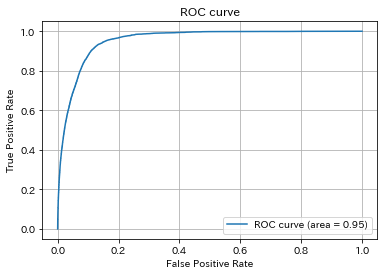

In [10]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
predict_y=0.4*watch_point+0.6*nyuusatsu_point
test_y=valid_df.watchtag+valid_df.nyuusatsutag
test_y=test_y.map(lambda x:1 if x>0 else 0)
# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(test_y, predict_y)

# ついでにAUCも
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [15]:
importance = pd.DataFrame(watch_model.feature_importance(), index=train_df.drop(["KaiinID","AuctionID","watchtag","nyuusatsutag"],axis=1).columns, columns=['importance'])

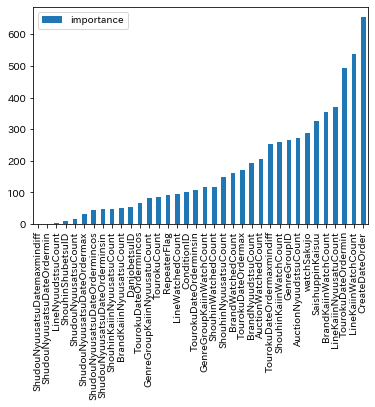

In [25]:
import seaborn as sns
importance.sort_values("importance").plot.bar()

In [26]:
importance.sort_values("importance")

,importance
ShudouNyuusatsuDatemaxmindiff,0
ShudouNyuusatsuDateOrdermin,0
LineNyuudstsuCount,4
ShouhinShubetsuID,9
ShudouNyuusatsuCount,16
ShudouNyuusatsuDateOrdermax,33
ShudouNyuusatsuDateOrdermincos,44
ShudouNyuusatsuDateOrderminsin,48
ShouhinKaiinNyuusatsuCount,49
BrandKaiinNyuusatsuCount,50


In [31]:
i=2
addtionaltable=pd.DataFrame({"KaiinID":pd.Series([num[i]]*20),"AuctionID":kari["AuctionID"].reset_index(drop=True),"Point":pd.Series([0]*20)})
pd.concat([pd.concat([predict[predict.KaiinID==num[i]],addtionaltable]).reset_index(drop=True)[["KaiinID","AuctionID"]],
                    pd.concat([predict[predict.KaiinID==num[i]],addtionaltable]).Point.rank(method='first',ascending=False).reset_index(drop=True)],axis=1).sort_values("Point").head(60)

,KaiinID,AuctionID,Point
11,63,65928,1.0
176,63,910735,2.0
443,63,2495322,3.0
495,63,2771026,4.0
208,63,1122181,5.0
710,63,3938504,6.0
537,63,3022159,7.0
254,63,1412664,8.0
73,63,460429,9.0
297,63,1695440,10.0


In [29]:
addtionaltable

,KaiinID,AuctionID,Point
0,277891,466995,0
1,277891,1989039,0
2,277891,1978705,0
3,277891,2848413,0
4,277891,4017246,0
5,277891,287233,0
6,277891,3790739,0
7,277891,2580246,0
8,277891,3818167,0
9,277891,3068866,0


In [21]:
predict[predict.KaiinID==40].sort_values("Point",ascending=False).Point.rank(method='first',ascending=False)

4      1.0
0      2.0
12     3.0
10     4.0
16     5.0
1      6.0
17     7.0
7      8.0
5      9.0
3     10.0
11    11.0
15    12.0
8     13.0
14    14.0
6     15.0
13    16.0
2     17.0
9     18.0
Name: Point, dtype: float64

In [67]:
train_df.loc[:,['KaiinID'
,'AuctionID'
,'watchtag'
,'nyuusatsutag'
,'SaishuppinKaisuu'
,'ConditionID'
,'DanjobetsuID'
,'CreateDateOrder'
,'TourokuCount'
,'TourokuDateOrdermin'
,'TourokuDateOrdermax'
,'TourokuDateOrdermaxmindiff'
,'TourokuDateOrderminsin'
,'TourokuDateOrdermincos'
,'watchSakujo'
,'AuctionWatchedCount'
,'ShouhinWatchedCount'
,'BrandWatchedCount'
,'LineWatchedCount'
,'ShouhinKaiinWatchCount'
,'BrandKaiinWatchCount'
,'GenreGroupKaiinWatchCount'
,'LineKaiinWatchCount'
,'ShudouNyuusatsuCount'
,'ShudouNyuusatsuDateOrdermin'
,'ShudouNyuusatsuDateOrdermax'
,'ShudouNyuusatsuDatemaxmindiff'
,'ShudouNyuusatsuDateOrderminsin'
,'ShudouNyuusatsuDateOrdermincos'
,'AuctionNyuudstsuCount'
,'ShouhinNyuusatsuCount'
,'BrandNyuudstsuCount'
,'LineNyuudstsuCount'
,'ShouhinKaiinNyuusatsuCount'
,'BrandKaiinNyuusatsuCount'
,'GenreGroupKaiinNyuusatuCount'
,'LineKaiinNyuusatuCount']].tail(50)

,KaiinID,AuctionID,watchtag,nyuusatsutag,SaishuppinKaisuu,ConditionID,DanjobetsuID,CreateDateOrder,TourokuCount,TourokuDateOrdermin,...,ShudouNyuusatsuDateOrderminsin,ShudouNyuusatsuDateOrdermincos,AuctionNyuudstsuCount,ShouhinNyuusatsuCount,BrandNyuudstsuCount,LineNyuudstsuCount,ShouhinKaiinNyuusatsuCount,BrandKaiinNyuusatsuCount,GenreGroupKaiinNyuusatuCount,LineKaiinNyuusatuCount
13310407,277891,4055075,0.0,0.0,0,6,2,125,-1.0,-1.0,...,-1.000000,-1.000000,-1.0,-1.0,20.0,539407.0,-1.0,-1.0,29.0,91.0
13310408,277891,4055075,0.0,0.0,0,6,2,118,-1.0,-1.0,...,-1.000000,-1.000000,-1.0,-1.0,20.0,529031.0,-1.0,-1.0,29.0,87.0
13310409,277891,4059566,0.0,0.0,0,6,2,57,1.0,3.0,...,-1.000000,-1.000000,-1.0,-1.0,329.0,560636.0,-1.0,-1.0,29.0,92.0
13310410,277891,4061278,0.0,0.0,0,6,2,444,1.0,328.0,...,-1.000000,-1.000000,-1.0,-1.0,135.0,560636.0,-1.0,-1.0,8.0,92.0
13310411,277891,4061278,0.0,0.0,0,6,2,437,1.0,321.0,...,-1.000000,-1.000000,-1.0,-1.0,134.0,549648.0,-1.0,-1.0,8.0,92.0
13310412,277891,4061278,0.0,0.0,0,6,2,430,1.0,314.0,...,-1.000000,-1.000000,-1.0,-1.0,134.0,539407.0,-1.0,-1.0,8.0,91.0
13310413,277891,4061278,0.0,0.0,0,6,2,423,1.0,307.0,...,-1.000000,-1.000000,-1.0,-1.0,133.0,529031.0,-1.0,-1.0,5.0,87.0
13310414,277891,4067762,0.0,0.0,0,6,0,397,1.0,290.0,...,-1.000000,-1.000000,-1.0,-1.0,19.0,560636.0,-1.0,-1.0,18.0,92.0
13310415,277891,4067762,0.0,0.0,0,6,0,390,1.0,283.0,...,-1.000000,-1.000000,-1.0,-1.0,19.0,549648.0,-1.0,-1.0,18.0,92.0
13310416,277891,4067762,0.0,0.0,0,6,0,383,1.0,276.0,...,-1.000000,-1.000000,-1.0,-1.0,19.0,539407.0,-1.0,-1.0,17.0,91.0


In [ ]:
import lightgbm as lgb
watch_train = lgb.Dataset(train_df.drop(
    ["KaiinID", "AuctionID", "watchtag", "nyuusatsutag"], axis=1), train_df.watchtag)
nyuusatsu_train = lgb.Dataset(train_df.drop(
    ["KaiinID", "AuctionID", "watchtag", "nyuusatsutag"], axis=1), train_df.nyuusatsutag)

# LightGBM のハイパーパラメータ
lgbm_params = {
    # 二値分類問題
    'objective': 'binary',
    # AUC の最大化を目指す
    "nround": 500,
    "learning_rate": 0.01,
    "max_depth": 6,
    "num_leaves": 127,
    "verbosity": -1,
    "random_seed": 0,
}
for i in tqdm(range(2)):
    if i==0:
        watch_model = lgb.train(lgbm_params, watch_train)
    else:
        nyuusatsu_model = lgb.train(lgbm_params, nyuusatsu_train)

test_df = createfeature(submission, watchlist,
                        shudounyuusatsu, rakusatsu, dateorder,auction)

test_df["watchtag"] = -1
test_df["nyuusatsutag"] = -1

watch_point=watch_model.predict(test_df.drop(
    ["KaiinID", "AuctionID", "watchtag", "nyuusatsutag"], axis=1))

nyuusatsu_point=nyuusatsu_model.predict(test_df.drop(
    ["KaiinID", "AuctionID", "watchtag", "nyuusatsutag"], axis=1))

predict = test_df[["KaiinID", "AuctionID"]]
predict["Point"] = 0.4*watch_point+0.6*nyuusatsu_point
# auction = pd.read_csv("data/auction.csv")
# auction["CreateDateOrder"] = auction.CreateDate.map(lambda x: x[0:10]).map(
#     lambda x: datetime.strptime(x, '%Y-%m-%d'))-datetime.strptime('2019-10-01', '%Y-%m-%d')
# auction["CreateDateOrder"] = auction.CreateDateOrder.map(
#     lambda x: x.days).map(int)
kari = auction[auction.CreateDateOrder == dateorder-5].sample(n=20, random_state=0)
addtionaltable = kari["AuctionID"]

num=submission.T.values[0]


for i in range(len(num)):
    
    addtionaltable=pd.DataFrame({"KaiinID":pd.Series([num[i]]*20),"AuctionID":kari["AuctionID"].reset_index(drop=True),"Point":pd.Series([0]*20)})
    

    sub1=pd.concat([pd.concat([predict[predict.KaiinID==num[i]],addtionaltable]).reset_index(drop=True)[["KaiinID","AuctionID"]],
                    pd.concat([predict[predict.KaiinID==num[i]],addtionaltable]).Point.rank(method='first',ascending=False).reset_index(drop=True)],axis=1)
# .rank(method='first',ascending=False).Point
    if i==0:
        sub=sub1[(0<sub1.Point)&(sub1.Point<21)]
    else:
        sub=pd.concat([sub,sub1[(0<sub1.Point)&(sub1.Point<21)]])
    if i%100==0:
        print(str(i)+"回目")
sub[["KaiinID","AuctionID"]].to_csv("submission.csv",index = False)

In [11]:
for i in train_df.columns:
    print(i)
#coloridいらない
#createdateorder

KaiinID
AuctionID
SaishuppinKaisuu
ConditionID
ColorID
DanjobetsuID
TourokuDateOrdermax
TourokuDateOrdermin
TourokuCount
TourokuDatemaxmindiff
TourokuDateOrderminsin
TourokuDateOrdermincos
ShouhinWatchedCount
AuctionWatchedCount
BrandWatchedCount
LineWatchedCount
ShouhinKaiinWatchCount
BrandKaiinWatchCount
GenreGroupKaiinWatchCount
LineKaiinWatchCount
ShudouNyuusatsuDateOrdermax
ShudouNyuusatsuDateOrdermin
ShudouNyuusatsuCount
ShudouNyuusatsuDatemaxmindiff
ShudouNyuusatsuDateOrderminsin
ShudouNyuusatsuDateOrdermincos
AuctionNyuudstsuCount
ShouhinNyuusatsuCount
KaiinNyuudstsuCount
BrandNyuudstsuCount
LineNyuudstsuCount
ShouhinKaiinNyuusatsuCount
BrandKaiinNyuusatsuCount
GenreGroupKaiinNyuusatuCount
LineKaiinNyuusatuCount
watchtag
nyuusatsutag


In [7]:
from tqdm import tqdm
import numpy as np
train_df=None
i=1
dateorder = -7


for i in tqdm(range(1,3)):
    # watchlist.TourokuDateOrder=dateorder - watchlist.TourokuDateOrder
    inputdateorder= dateorder-7*i
    train_watch=watchlist[(watchlist.TourokuDateOrder>=dateorder-7*i)&(watchlist.TourokuDateOrder<dateorder-7*i+7)].copy()
    train_watch["tag"]=1
    train_watch=train_watch[["KaiinID","AuctionID","tag"]]

    train_nyuusatsu=shudounyuusatsu[(shudounyuusatsu.ShudouNyuusatsuDateOrder>=dateorder-7*i)&(shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i+7)].copy()
    train_nyuusatsu["tag"]=2
    train_nyuusatsu=train_nyuusatsu[["KaiinID","AuctionID","tag"]]
    train_ref_df=pd.concat([train_nyuusatsu,train_watch])
    # .groupby(["KaiinID","AuctionID"]).max().reset_index()
    train_KaiinID=pd.Series(train_ref_df.KaiinID.unique())
    train_KaiinID.name="KaiinID"
    train_KaiinID=pd.DataFrame(train_KaiinID)
    train_watchlist=watchlist[watchlist.TourokuDateOrder < dateorder-7*i].copy()
    train_shudounyuusatsu=shudounyuusatsu[shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i].copy()
    train_rakusatsu=rakusatsu[rakusatsu.RakusatsuDateOrder<dateorder-7*i].copy()

    train_df_child=createfeature(train_KaiinID, train_watchlist, train_shudounyuusatsu, train_rakusatsu, dateorder-7*i,auction)
    watch_kari=watchlist[(watchlist.TourokuDateOrder>=dateorder-7*i)&(watchlist.TourokuDateOrder<dateorder-7*i+7)].copy()
    watch_kari["watchtag"]=1
    watch_kari=watch_kari[["KaiinID","AuctionID","watchtag"]]
    watch_kari=watch_kari[~watch_kari.duplicated()]
    train_df_child=pd.merge(train_df_child,watch_kari,how="left")
    shudounyuusatsu_kari=shudounyuusatsu[(shudounyuusatsu.ShudouNyuusatsuDateOrder>=dateorder-7*i)&(shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i+7)].copy()
    shudounyuusatsu_kari["nyuusatsutag"]=1
    shudounyuusatsu_kari=shudounyuusatsu_kari[["KaiinID","AuctionID","nyuusatsutag"]]
    shudounyuusatsu_kari=shudounyuusatsu_kari[~shudounyuusatsu_kari.duplicated()]
    train_df_child=pd.merge(train_df_child,shudounyuusatsu_kari,how="left")
    train_df_child=train_df_child.fillna(0)

    train_df=pd.concat([train_df,train_df_child]).sort_values(["KaiinID","AuctionID"]).reset_index(drop=True)



  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [02:20<02:20, 140.71s/it]

100%|██████████| 2/2 [09:58<00:00, 299.43s/it]


In [38]:
train_df[list(train_df.columns)[4:]]

,SaishuppinKaisuu,ConditionID,DanjobetsuID,CreateDateOrder,TourokuCount,TourokuDateOrdermin,TourokuDateOrdermax,TourokuDateOrdermaxmindiff,TourokuDateOrderminsin,TourokuDateOrdermincos,...,ShudouNyuusatsuDateOrderminsin,ShudouNyuusatsuDateOrdermincos,AuctionNyuudstsuCount,ShouhinNyuusatsuCount,BrandNyuudstsuCount,LineNyuudstsuCount,ShouhinKaiinNyuusatsuCount,BrandKaiinNyuusatsuCount,GenreGroupKaiinNyuusatuCount,LineKaiinNyuusatuCount
0,0,7,0,217,-1.0,-1.0,-1.0,NaN,-1.000000,-1.000000,...,-1.0,-1.0,-1.0,-1.0,4438.0,560636.0,-1.0,-1.0,-1.0,-1.0
1,0,6,0,86,1.0,33.0,33.0,NaN,0.999912,-0.013277,...,-1.0,-1.0,1.0,2.0,16704.0,560636.0,-1.0,-1.0,-1.0,-1.0
2,0,6,2,89,1.0,33.0,33.0,NaN,0.999912,-0.013277,...,-1.0,-1.0,-1.0,-1.0,1860.0,560636.0,-1.0,-1.0,-1.0,-1.0
3,0,8,0,61,1.0,33.0,33.0,NaN,0.999912,-0.013277,...,-1.0,-1.0,-1.0,-1.0,1114.0,560636.0,-1.0,-1.0,-1.0,-1.0
4,235,6,0,151,1.0,33.0,33.0,NaN,0.999912,-0.013277,...,-1.0,-1.0,-1.0,-1.0,4438.0,560636.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13310452,0,6,0,273,1.0,272.0,272.0,NaN,0.968357,-0.249569,...,-1.0,-1.0,1.0,1.0,40.0,529031.0,-1.0,-1.0,1.0,87.0
13310453,0,6,0,101,1.0,84.0,84.0,NaN,0.733190,-0.680023,...,-1.0,-1.0,1.0,1.0,1500.0,560636.0,-1.0,1.0,1.0,92.0
13310454,0,6,0,94,1.0,77.0,77.0,NaN,0.999520,-0.030975,...,-1.0,-1.0,1.0,1.0,1491.0,549648.0,-1.0,1.0,1.0,92.0
13310455,0,6,0,87,1.0,70.0,70.0,NaN,0.773891,0.633319,...,-1.0,-1.0,1.0,1.0,1484.0,539407.0,-1.0,1.0,1.0,91.0


In [46]:
import lightgbm as lgb
watch_train = lgb.Dataset(train_df.drop(["KaiinID","AuctionID","watchtag","nyuusatsutag"],axis=1), label=train_df.watchtag)
nyuusatsu_train = lgb.Dataset(train_df.drop(["KaiinID","AuctionID","watchtag","nyuusatsutag"],axis=1), label=train_df.nyuusatsutag)

# LightGBM のハイパーパラメータ
lgbm_params = {
    # 二値分類問題
    'objective': 'binary',
    "nround": 500,
    "learning_rate": 0.01,
    "max_depth": 6,
    "num_leaves": 127,
    "verbosity": -1,
    "random_seed": 0,
}
for i in tqdm(range(2)):
    if i==0:
        watch_model = lgb.train(lgbm_params, watch_train)
    else:
        nyuusatsu_model = lgb.train(lgbm_params, nyuusatsu_train)

test_df = createfeature(submission, watchlist,
                        shudounyuusatsu, rakusatsu, dateorder,auction)

test_df["watchtag"] = -1
test_df["nyuusatsutag"] = -1

watch_point=watch_model.predict(test_df.drop(["KaiinID","AuctionID","watchtag","nyuusatsutag"],axis=1), axis=1)

nyuusatsu_point=nyuusatsu_model.predict(test_df.drop(["KaiinID","AuctionID","watchtag","nyuusatsutag"],axis=1), axis=1)

predict = test_df[["KaiinID", "AuctionID"]]
predict["Point"] = 0.4*watch_point+0.6*nyuusatsu_point
# auction = pd.read_csv("data/auction.csv")
# auction["CreateDateOrder"] = auction.CreateDate.map(lambda x: x[0:10]).map(
#     lambda x: datetime.strptime(x, '%Y-%m-%d'))-datetime.strptime('2019-10-01', '%Y-%m-%d')
# auction["CreateDateOrder"] = auction.CreateDateOrder.map(
#     lambda x: x.days).map(int)
kari = auction[auction.CreateDateOrder == dateorder-5].sample(n=20, random_state=0)
addtionaltable = kari["AuctionID"]

num=submission.T.values[0]


for i in range(len(num)):
    
    addtionaltable=pd.DataFrame({"KaiinID":pd.Series([num[i]]*20),"AuctionID":kari["AuctionID"].reset_index(drop=True),"Point":pd.Series([0]*20)})
    

    sub1=pd.concat([pd.concat([predict[predict.KaiinID==num[i]],addtionaltable]).reset_index(drop=True)[["KaiinID","AuctionID"]],
                    pd.concat([predict[predict.KaiinID==num[i]],addtionaltable]).Point.rank(method='first',ascending=False).reset_index(drop=True)],axis=1).sort_values("Point")
# .rank(method='first',ascending=False).Point
    if i==0:
        sub=sub1[(0<sub1.Point)&(sub1.Point<21)]
    else:
        sub=pd.concat([sub,sub1[(0<sub1.Point)&(sub1.Point<21)]])
    if i%100==0:
        print(str(i)+"回目")
sub[["KaiinID","AuctionID"]].to_csv("submission.csv",index = False)

  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [41]:
predict

,KaiinID,AuctionID
0,40,90122
1,40,305450
2,40,371929
3,40,377503
4,40,471023
...,...,...
3553830,277891,4089851
3553831,277891,4090315
3553832,277891,4097355
3553833,277891,4104172


In [30]:
i=1
addtionaltable=pd.DataFrame({"KaiinID":pd.Series([num[i]]*20),"AuctionID":kari["AuctionID"].reset_index(drop=True),"Point":pd.Series([0]*20)})
pd.concat([pd.concat([predict[predict.KaiinID==num[i]],addtionaltable]).reset_index(drop=True)[["KaiinID","AuctionID"]],
                    pd.concat([predict[predict.KaiinID==num[i]],addtionaltable]).Point.rank(method='first',ascending=False).reset_index(drop=True)],axis=1).sort_values("Point")

,KaiinID,AuctionID,Point
4,40,471023,1.0
0,40,90122,2.0
12,40,2310661,3.0
10,40,1553943,4.0
7,40,671186,5.0
1,40,305450,6.0
16,40,3489583,7.0
17,40,3711107,8.0
5,40,487042,9.0
3,40,377503,10.0


In [15]:
i=1
inputdateorder= dateorder-7*i
train_watch=watchlist[(watchlist.TourokuDateOrder>=dateorder-7*i)&(watchlist.TourokuDateOrder<dateorder-7*i+7)].copy()
train_watch["tag"]=1
train_watch=train_watch[["KaiinID","AuctionID","tag"]]

train_nyuusatsu=shudounyuusatsu[(shudounyuusatsu.ShudouNyuusatsuDateOrder>=dateorder-7*i)&(shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i+7)].copy()
train_nyuusatsu["tag"]=2
train_nyuusatsu=train_nyuusatsu[["KaiinID","AuctionID","tag"]]
train_ref_df=pd.concat([train_nyuusatsu,train_watch])
# .groupby(["KaiinID","AuctionID"]).max().reset_index()
train_KaiinID=pd.Series(train_ref_df.KaiinID.unique())
train_KaiinID.name="KaiinID"
train_KaiinID=pd.DataFrame(train_KaiinID)
train_watchlist=watchlist[watchlist.TourokuDateOrder < dateorder-7*i].copy()
train_shudounyuusatsu=shudounyuusatsu[shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i].copy()
train_rakusatsu=rakusatsu[rakusatsu.RakusatsuDateOrder<dateorder-7*i].copy()

train_df_child=createfeature(train_KaiinID, train_watchlist, train_shudounyuusatsu, train_rakusatsu, dateorder-7*i,auction)

train_df_child.loc[:,['KaiinID'
,'AuctionID'
# ,'watchtag'
# ,'nyuusatsutag'
,'SaishuppinKaisuu'
,'ConditionID'
,'DanjobetsuID'
,'CreateDateOrder'
,'TourokuCount'
,'TourokuDateOrdermin'
,'TourokuDateOrdermax'
,'TourokuDateOrdermaxmindiff'
,'TourokuDateOrderminsin'
,'TourokuDateOrdermincos'
,'watchSakujo'
,'AuctionWatchedCount'
,'ShouhinWatchedCount'
,'BrandWatchedCount'
,'LineWatchedCount'
,'ShouhinKaiinWatchCount'
,'BrandKaiinWatchCount'
,'GenreGroupKaiinWatchCount'
,'LineKaiinWatchCount'
,'ShudouNyuusatsuCount'
,'ShudouNyuusatsuDateOrdermin'
,'ShudouNyuusatsuDateOrdermax'
,'ShudouNyuusatsuDatemaxmindiff'
,'ShudouNyuusatsuDateOrderminsin'
,'ShudouNyuusatsuDateOrdermincos'
,'AuctionNyuudstsuCount'
,'ShouhinNyuusatsuCount'
,'BrandNyuudstsuCount'
,'LineNyuudstsuCount'
,'ShouhinKaiinNyuusatsuCount'
,'BrandKaiinNyuusatsuCount'
,'GenreGroupKaiinNyuusatuCount'
,'LineKaiinNyuusatuCount']].tail(50)


,KaiinID,AuctionID,SaishuppinKaisuu,ConditionID,DanjobetsuID,CreateDateOrder,TourokuCount,TourokuDateOrdermin,TourokuDateOrdermax,TourokuDateOrdermaxmindiff,...,ShudouNyuusatsuDateOrderminsin,ShudouNyuusatsuDateOrdermincos,AuctionNyuudstsuCount,ShouhinNyuusatsuCount,BrandNyuudstsuCount,LineNyuudstsuCount,ShouhinKaiinNyuusatsuCount,BrandKaiinNyuusatsuCount,GenreGroupKaiinNyuusatuCount,LineKaiinNyuusatuCount
3445727,277891,3898863,0,5,0,62,-1.0,-1.0,-1.0,NaN,...,-1.000000,-1.000000,-1.0,-1.0,15762.0,560636.0,-1.0,-1.0,18.0,92.0
3445728,277891,3900680,0,6,2,476,-1.0,-1.0,-1.0,NaN,...,-1.000000,-1.000000,-1.0,1.0,118.0,560636.0,1.0,2.0,8.0,92.0
3445729,277891,3900874,0,6,0,187,-1.0,-1.0,-1.0,NaN,...,-1.000000,-1.000000,-1.0,-1.0,15762.0,560636.0,-1.0,-1.0,18.0,92.0
3445730,277891,3901333,0,6,2,153,-1.0,-1.0,-1.0,NaN,...,-1.000000,-1.000000,-1.0,1.0,280.0,560636.0,1.0,1.0,29.0,92.0
3445731,277891,3902652,0,6,2,333,1.0,332.0,332.0,NaN,...,-1.000000,-1.000000,2.0,2.0,111.0,560636.0,-1.0,-1.0,-1.0,92.0
3445732,277891,3904426,250,6,0,136,1.0,20.0,20.0,NaN,...,-1.000000,-1.000000,-1.0,-1.0,15762.0,560636.0,-1.0,-1.0,18.0,92.0
3445733,277891,3909903,0,7,2,138,-1.0,-1.0,-1.0,NaN,...,-1.000000,-1.000000,-1.0,-1.0,21.0,560636.0,-1.0,-1.0,29.0,92.0
3445734,277891,3921625,0,6,0,151,-1.0,-1.0,-1.0,NaN,...,-1.000000,-1.000000,-1.0,1.0,12.0,560636.0,1.0,1.0,18.0,92.0
3445735,277891,3925149,0,8,2,135,1.0,115.0,115.0,NaN,...,-1.000000,-1.000000,-1.0,-1.0,9.0,560636.0,-1.0,-1.0,-1.0,92.0
3445736,277891,3926743,0,6,0,463,1.0,335.0,335.0,NaN,...,-1.000000,-1.000000,-1.0,-1.0,1116.0,560636.0,-1.0,1.0,-1.0,92.0


In [19]:
train_df.loc[:,['KaiinID'
,'AuctionID'
,'watchtag'
,'nyuusatsutag'
,'SaishuppinKaisuu'
,'ConditionID'
,'DanjobetsuID'
,'CreateDateOrder'
,'TourokuCount'
,'TourokuDateOrdermin'
,'TourokuDateOrdermax'
,'TourokuDateOrdermaxmindiff'
,'TourokuDateOrderminsin'
,'TourokuDateOrdermincos'
,'watchSakujo'
,'AuctionWatchedCount'
,'ShouhinWatchedCount'
,'BrandWatchedCount'
,'LineWatchedCount'
,'ShouhinKaiinWatchCount'
,'BrandKaiinWatchCount'
,'GenreGroupKaiinWatchCount'
,'LineKaiinWatchCount'
,'ShudouNyuusatsuCount'
,'ShudouNyuusatsuDateOrdermin'
,'ShudouNyuusatsuDateOrdermax'
,'ShudouNyuusatsuDatemaxmindiff'
,'ShudouNyuusatsuDateOrderminsin'
,'ShudouNyuusatsuDateOrdermincos'
,'AuctionNyuudstsuCount'
,'ShouhinNyuusatsuCount'
,'BrandNyuudstsuCount'
,'LineNyuudstsuCount'
,'ShouhinKaiinNyuusatsuCount'
,'BrandKaiinNyuusatsuCount'
,'GenreGroupKaiinNyuusatuCount'
,'LineKaiinNyuusatuCount']].sort_values(["KaiinID","AuctionID"]).tail(50)

,KaiinID,AuctionID,watchtag,nyuusatsutag,SaishuppinKaisuu,ConditionID,DanjobetsuID,CreateDateOrder,TourokuCount,TourokuDateOrdermin,...,ShudouNyuusatsuDateOrderminsin,ShudouNyuusatsuDateOrdermincos,AuctionNyuudstsuCount,ShouhinNyuusatsuCount,BrandNyuudstsuCount,LineNyuudstsuCount,ShouhinKaiinNyuusatsuCount,BrandKaiinNyuusatsuCount,GenreGroupKaiinNyuusatuCount,LineKaiinNyuusatuCount
6818926,277891,4004013,0.0,0.0,304,5,2,76,1.0,76.0,...,-1.000000,-1.000000,-1.0,-1.0,621.0,549648.0,-1.0,-1.0,8.0,92.0
6818927,277891,4005307,0.0,0.0,0,6,0,308,1.0,283.0,...,-1.000000,-1.000000,-1.0,-1.0,1500.0,560636.0,-1.0,1.0,18.0,92.0
6818928,277891,4005307,0.0,0.0,0,6,0,301,1.0,276.0,...,-1.000000,-1.000000,-1.0,-1.0,1491.0,549648.0,-1.0,1.0,18.0,92.0
6818929,277891,4005693,0.0,0.0,253,6,2,134,1.0,43.0,...,-1.000000,-1.000000,-1.0,-1.0,3.0,560636.0,-1.0,-1.0,8.0,92.0
6818930,277891,4005693,0.0,0.0,253,6,2,127,1.0,36.0,...,-1.000000,-1.000000,-1.0,-1.0,3.0,549648.0,-1.0,-1.0,8.0,92.0
6818931,277891,4017124,0.0,0.0,0,6,2,439,1.0,285.0,...,-1.000000,-1.000000,-1.0,-1.0,2378.0,560636.0,-1.0,-1.0,29.0,92.0
6818932,277891,4017124,0.0,0.0,0,6,2,432,1.0,278.0,...,-1.000000,-1.000000,-1.0,-1.0,2305.0,549648.0,-1.0,-1.0,29.0,92.0
6818933,277891,4022198,0.0,0.0,0,6,0,81,1.0,65.0,...,-1.000000,-1.000000,-1.0,-1.0,125.0,560636.0,-1.0,-1.0,11.0,92.0
6818934,277891,4022198,0.0,0.0,0,6,0,74,1.0,58.0,...,-1.000000,-1.000000,-1.0,-1.0,121.0,549648.0,-1.0,-1.0,11.0,92.0
6818935,277891,4030207,0.0,0.0,0,7,2,308,1.0,308.0,...,-1.000000,-1.000000,-1.0,-1.0,50.0,560636.0,-1.0,-1.0,29.0,92.0


In [33]:
auction[auction.CreateDateOrder == dateorder-5]

,AuctionID,ShouhinShubetsuID,ShouhinID,SaishuppinKaisuu,ConditionID,BrandID,GenreID,GenreGroupID,LineID,ColorID,DanjobetsuID,SankouKakaku,CreateDate,CreateDateOrder
1895505,3510091,1,2262826,0,6,772,341,312,0,188,0,1580,2019-09-12 09:30:02,-12
1895506,3592300,1,2883186,0,6,5340,320,312,0,175,0,1000,2019-09-12 09:30:02,-12
1895507,3785373,1,2152844,0,7,8220,320,312,0,0,0,1360,2019-09-12 09:30:02,-12
1895508,3868958,1,2071126,0,6,742,327,312,0,0,0,1000,2019-09-12 09:30:03,-12
1895509,2216612,1,417404,0,6,1085,321,312,0,15,0,15000,2019-09-12 09:30:03,-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903143,3912094,1,2670693,0,7,70,320,312,0,314,0,60000,2019-09-12 09:35:26,-12
1903144,459664,1,288811,0,6,38,341,312,0,15,0,48000,2019-09-12 09:35:26,-12
1903145,232054,1,160992,0,7,25,321,312,0,15,0,73000,2019-09-12 09:35:26,-12
1903146,3530530,1,531617,351,7,70,341,312,0,0,0,40000,2019-09-12 09:35:26,-12


In [3]:
from tqdm import tqdm
train_df=None
i=1
dateorder = -7
for i in tqdm(range(1,3)):
    print(i)
    train_watch=watchlist[(watchlist.TourokuDateOrder>=dateorder-7*i)&(watchlist.TourokuDateOrder<dateorder-7*i+7)]
    train_watch["tag"]=1
    train_watch=train_watch[["KaiinID","AuctionID","tag"]]

    train_nyuusatsu=shudounyuusatsu[(shudounyuusatsu.ShudouNyuusatsuDateOrder>=dateorder-7*i)&(shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i+7)]
    train_nyuusatsu["tag"]=2
    train_nyuusatsu=train_nyuusatsu[["KaiinID","AuctionID","tag"]]

    train_ref_df=pd.concat([train_nyuusatsu,train_watch]).groupby(["KaiinID","AuctionID"]).max().reset_index()

    train_KaiinID=pd.Series(train_ref_df.KaiinID.unique())
    train_KaiinID.name="KaiinID"
    train_KaiinID=pd.DataFrame(train_KaiinID)

    train_watchlist=watchlist[watchlist.TourokuDateOrder < dateorder-7*i]

    train_shudounyuusatsu=shudounyuusatsu[shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i]

    train_rakusatsu=rakusatsu[rakusatsu.RakusatsuDateOrder<dateorder-7*i]

    train_df_child=createfeature(train_KaiinID, train_watchlist, train_shudounyuusatsu, train_rakusatsu, dateorder-7*i,auction)

    watch_kari=watchlist[(watchlist.TourokuDateOrder>=dateorder-7*i)&(watchlist.TourokuDateOrder<dateorder-7*i+7)]
    watch_kari["watchtag"]=1
    watch_kari=watch_kari[["KaiinID","AuctionID","watchtag"]]
    watch_kari=watch_kari[~watch_kari.duplicated()]
    train_df_child=pd.merge(train_df_child,watch_kari,how="left")
    shudounyuusatsu_kari=shudounyuusatsu[(shudounyuusatsu.ShudouNyuusatsuDateOrder>=dateorder-7*i)&(shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i+7)]
    shudounyuusatsu_kari["nyuusatsutag"]=1
    shudounyuusatsu_kari=shudounyuusatsu_kari[["KaiinID","AuctionID","nyuusatsutag"]]
    shudounyuusatsu_kari=shudounyuusatsu_kari[~shudounyuusatsu_kari.duplicated()]
    train_df_child=pd.merge(train_df_child,shudounyuusatsu_kari,how="left")
    train_df_child=train_df_child.fillna(0)

    train_df=pd.concat([train_df,train_df_child])
    train_df

  0%|          | 0/2 [00:00<?, ?it/s]

1


  0%|          | 0/2 [00:02<?, ?it/s]


NameError: name 'createfeature' is not defined

In [18]:
train_df.tail(50)

,KaiinID,AuctionID,SaishuppinKaisuu,ConditionID,DanjobetsuID,CreateDateOrder,TourokuDateOrdermax,TourokuDateOrdermin,TourokuCount,TourokuDatemaxmindiff,...,AuctionNyuudstsuCount,ShouhinNyuusatsuCount,BrandNyuudstsuCount,LineNyuudstsuCount,ShouhinKaiinNyuusatsuCount,BrandKaiinNyuusatsuCount,GenreGroupKaiinNyuusatuCount,LineKaiinNyuusatuCount,watchtag,nyuusatsutag
6818926,277891,4004013,304,5,2,76,76.0,76.0,1.0,0.0,...,-1.0,-1.0,621.0,549648.0,-1.0,-1.0,8.0,92.0,0.0,0.0
6818927,277891,4005307,0,6,0,308,283.0,283.0,1.0,0.0,...,-1.0,-1.0,1500.0,560636.0,-1.0,1.0,18.0,92.0,0.0,0.0
6818928,277891,4005307,0,6,0,301,276.0,276.0,1.0,0.0,...,-1.0,-1.0,1491.0,549648.0,-1.0,1.0,18.0,92.0,0.0,0.0
6818929,277891,4005693,253,6,2,134,43.0,43.0,1.0,0.0,...,-1.0,-1.0,3.0,560636.0,-1.0,-1.0,8.0,92.0,0.0,0.0
6818930,277891,4005693,253,6,2,127,36.0,36.0,1.0,0.0,...,-1.0,-1.0,3.0,549648.0,-1.0,-1.0,8.0,92.0,0.0,0.0
6818931,277891,4017124,0,6,2,439,285.0,285.0,1.0,0.0,...,-1.0,-1.0,2378.0,560636.0,-1.0,-1.0,29.0,92.0,0.0,0.0
6818932,277891,4017124,0,6,2,432,278.0,278.0,1.0,0.0,...,-1.0,-1.0,2305.0,549648.0,-1.0,-1.0,29.0,92.0,0.0,0.0
6818933,277891,4022198,0,6,0,81,65.0,65.0,1.0,0.0,...,-1.0,-1.0,125.0,560636.0,-1.0,-1.0,11.0,92.0,0.0,0.0
6818934,277891,4022198,0,6,0,74,58.0,58.0,1.0,0.0,...,-1.0,-1.0,121.0,549648.0,-1.0,-1.0,11.0,92.0,0.0,0.0
6818935,277891,4030207,0,7,2,308,308.0,308.0,1.0,0.0,...,-1.0,-1.0,50.0,560636.0,-1.0,-1.0,29.0,92.0,0.0,0.0


In [23]:
watch_kari=watchlist[(watchlist.TourokuDateOrder>=dateorder-7*i)&(watchlist.TourokuDateOrder<dateorder-7*i+7)]
watch_kari["watchtag"]=1
watch_kari=watch_kari[["KaiinID","AuctionID","watchtag"]]
watch_kari=watch_kari[~watch_kari.duplicated()]
train_df_child=pd.merge(train_df_child,watch_kari,how="left")

In [24]:
train_df_child

KaiinID  AuctionID  SaishuppinKaisuu  ConditionID  ColorID  \
0         231713    1036190                 0            6       15   
1         231713    4106265                 0            6       68   
2          58564    4106265                 0            6       68   
3          81233    4106265                 0            6       68   
4          79459    4106265                 0            6       68   
...          ...        ...               ...          ...      ...   
3445772   223521    2810503                 0            6        0   
3445773   223521    1480392                 0            6        0   
3445774   223521    2670120                 0            6        0   
3445775   159619    4029340                 0            6       68   
3445776   159619    2200310                 0            6        0   

         DanjobetsuID  TourokuDateOrdermax  TourokuDateOrdermin  TourokuCount  \
0                   0                381.0                381.0           1.0   
1                   0                353.0                353.0           1.0   
2                   0                358.0                358.0           1.0   
3                   0                381.0                381.0           1.0   
4                   0                348.0                348.0           1.0   
...               ...                  ...                  ...           ...   
3445772             0                 -1.0                 -1.0          -1.0   
3445773             0                 -1.0                 -1.0          -1.0   
3445774             0                 -1.0                 -1.0          -1.0   
3445775             0                 -1.0                 -1.0          -1.0   
3445776             2                 -1.0                 -1.0          -1.0   

         TourokuDatemaxmindiff  ...  AuctionNyuudstsuCount  \
0                          0.0  ...                   -1.0   
1                          0.0  ...                   -1.0   
2                          0.0  ...                   -1.0   
3                          0.0  ...                   -1.0   
4                          0.0  ...                   -1.0   
...                        ...  ...                    ...   
3445772                   -1.0  ...                   -1.0   
3445773                   -1.0  ...                   -1.0   
3445774                   -1.0  ...                   -1.0   
3445775                   -1.0  ...                    1.0   
3445776                   -1.0  ...                    1.0   

         ShouhinNyuusatsuCount  KaiinNyuudstsuCount  BrandNyuudstsuCount  \
0                         -1.0                 45.0                317.0   
1                         -1.0                 45.0               4438.0   
2                         -1.0                 54.0               4438.0   
3                         -1.0                 47.0               4438.0   
4                         -1.0                 24.0               4438.0   
...                        ...                  ...                  ...   
3445772                    1.0                  1.0                  7.0   
3445773                    1.0                  1.0                  7.0   
3445774                    1.0                  1.0                  7.0   
3445775                    1.0                  2.0               4576.0   
3445776                    1.0                  2.0                  1.0   

         LineNyuudstsuCount  ShouhinKaiinNyuusatsuCount  \
0                  560636.0                        -1.0   
1                  560636.0                        -1.0   
2                  560636.0                        -1.0   
3                  560636.0                        -1.0   
4                  560636.0                        -1.0   
...                     ...                         ...   
3445772            560636.0                         1.0   
3445773            560636.0                         1

In [37]:
inputsubmission, inputwatchlist, inputshudounyuusatsu,inputrakusatsu, inputdateorder=submission,watchlist,shudounyuusatsu,rakusatsu,inputdateorder
df = pd.concat([inputwatchlist[["KaiinID", "ShouhinID"]],inputshudounyuusatsu[["KaiinID", "ShouhinID"]]])
df = df[df.duplicated() != True]

# df = pd.merge(df, auction[["AuctionID", "ShouhinID"]], on='ShouhinID')
# df = df[df.duplicated() != True][["KaiinID","AuctionID"]]

# df = pd.merge(df, inputsubmission, on="KaiinID")
# auction['CreateDateOrder'] = inputdateorder - auction['CreateDateOrder']
# df = pd.merge(df, auction[[
#     "AuctionID","ShouhinShubetsuID","ShouhinID","SaishuppinKaisuu",
#     "ConditionID","BrandID","GenreID","GenreGroupID","LineID","ColorID","DanjobetsuID",]])

# inputwatchlist.TourokuDateOrder = inputdateorder - inputwatchlist.TourokuDateOrder
# df = pd.merge(df,inputwatchlist.groupby(["KaiinID", "AuctionID"]).TourokuDateOrder.max().reset_index().rename(
#                   columns={'TourokuDateOrder': 'TourokuDateOrdermax'}),how='left')

# df = pd.merge(df,inputwatchlist.groupby(["KaiinID", "AuctionID"]).TourokuDateOrder.min().reset_index().rename(
#                   columns={'TourokuDateOrder': 'TourokuDateOrdermin'}),how='left')

# df = pd.merge(df,inputwatchlist.groupby(["KaiinID", "AuctionID"]).TourokuDateOrder.count().reset_index().rename(
#                   columns={'TourokuDateOrder': 'TourokuCount'}),how='left')

# df["TourokuDatemaxmindiff"] = df.TourokuDateOrdermax - df.TourokuDateOrdermin

# df = pd.merge(df,inputwatchlist.groupby(["KaiinID","AuctionID"]).SakujoFlag.max().reset_index().rename(
#                        columns={'SakujoFlag': 'watchSakujo'}),how='left')

# Shouhincount = pd.concat([pd.Series(list(inputwatchlist.groupby("ShouhinID").ShouhinID.count().index)),
#     pd.Series(inputwatchlist.groupby("ShouhinID").ShouhinID.count().values)],axis=1)
# Shouhincount.columns = ["ShouhinID", "ShouhinWatchedCount"]
# df = pd.merge(df, Shouhincount, how="left")

# Auctioncount = pd.concat([pd.Series(list(inputwatchlist.groupby("AuctionID").AuctionID.count().index)),
#     pd.Series(inputwatchlist.groupby("AuctionID").AuctionID.count().values)],axis=1)
# Auctioncount.columns = ["AuctionID", "AuctionWatchedCount"]
# Auctioncount
# df = pd.merge(df, Auctioncount, how="left")

# Brandcount = pd.concat([pd.Series(list(inputwatchlist.groupby("BrandID").BrandID.count().index)),
#                         pd.Series(inputwatchlist.groupby("BrandID").BrandID.count().values)],axis=1)
# Brandcount.columns = ["BrandID", "BrandWatchedCount"]
# Brandcount
# df = pd.merge(df, Brandcount, how="left")

# Linecount = pd.concat([
#     pd.Series(list(inputwatchlist.groupby("LineID").LineID.count().index)),
#     pd.Series(inputwatchlist.groupby("LineID").LineID.count().values)
# ],
#     axis=1)
# Linecount.columns = ["LineID", "LineWatchedCount"]
# df = pd.merge(df, Linecount, how="left")

# ShouhinKaiinWatchcount = inputwatchlist.groupby(["KaiinID", "ShouhinID"]).AuctionID.count()
# ShouhinKaiinWatchcount = ShouhinKaiinWatchcount.reset_index().rename(columns={"AuctionID": "ShouhinKaiinWatchCount"})
# df = pd.merge(df, ShouhinKaiinWatchcount, how="left")

# BrandKaiinWatchcount = inputwatchlist.groupby(["KaiinID", "BrandID"]).AuctionID.count()
# BrandKaiinWatchcount = BrandKaiinWatchcount.reset_index().rename(columns={"AuctionID": "BrandKaiinWatchCount"})
# df = pd.merge(df, BrandKaiinWatchcount, how="left")

# #     GenreKaiinWatchcount = inputwatchlist.groupby(
# #         ["KaiinID", "GenreID"]).AuctionID.count()
# #     GenreKaiinWatchcount = GenreKaiinWatchcount.reset_index().rename(
# #         columns={"AuctionID": "GenreKaiinWatchCount"})
# #     df = pd.merge(df, GenreKaiinWatchcount, how="left")

# GenreGroupKaiinWatchcount = inputwatchlist.groupby(["KaiinID", "GenreGroupID"]).AuctionID.count()
# GenreGroupKaiinWatchcount = GenreGroupKaiinWatchcount.reset_index().rename(columns={"AuctionID": "GenreGroupKaiinWatchCount"})
# df = pd.merge(df, GenreGroupKaiinWatchcount, how="left")

# LineKaiinWatchcount = inputwatchlist.groupby(["KaiinID","LineID"]).AuctionID.count()
# LineKaiinWatchcount = LineKaiinWatchcount.reset_index().rename(
#     columns={"AuctionID": "LineKaiinWatchCount"})
# df = pd.merge(df, LineKaiinWatchcount, how="left")

# inputshudounyuusatsu.ShudouNyuusatsuDateOrder = inputdateorder - \
#     inputshudounyuusatsu.ShudouNyuusatsuDateOrder
# df = pd.merge(df,inputshudounyuusatsu.groupby(["KaiinID", "AuctionID"]).ShudouNyuusatsuDateOrder.max().reset_index().rename(
#         columns={'ShudouNyuusatsuDateOrder': 'ShudouNyuusatsuDateOrdermax'}),how='left')

# df = pd.merge(df,inputshudounyuusatsu.groupby(["KaiinID", "AuctionID"]).ShudouNyuusatsuDateOrder.min().reset_index().rename(
#         columns={'ShudouNyuusatsuDateOrder': 'ShudouNyuusatsuDateOrdermin'}),how='left')

# df = pd.merge(df,inputshudounyuusatsu.groupby(["KaiinID", "AuctionID"]).ShudouNyuusatsuDateOrder.count().reset_index().rename(
#         columns={'ShudouNyuusatsuDateOrder': 'ShudouNyuusatsuCount'}),how='left')
# df["ShudouNyuusatsuDatemaxmindiff"] = df.ShudouNyuusatsuDateOrdermax - df.ShudouNyuusatsuDateOrdermin

# AuctionNyuusatsucount = pd.concat([pd.Series(list(inputshudounyuusatsu.groupby("AuctionID").AuctionID.count().index)),
#     pd.Series(inputshudounyuusatsu.groupby("AuctionID").AuctionID.count().values)],axis=1)
# AuctionNyuusatsucount.columns = ["AuctionID", "AuctionNyuudstsuCount"]
# df = pd.merge(df, AuctionNyuusatsucount, how="left")

# ShouhinNyuusatsucount = pd.concat([pd.Series(list(inputshudounyuusatsu.groupby("ShouhinID").ShouhinID.count().index)),
#     pd.Series(inputshudounyuusatsu.groupby("ShouhinID").AuctionID.count().values)],axis=1)
# ShouhinNyuusatsucount.columns = ["ShouhinID", "ShouhinNyuusatsuCount"]
# df = pd.merge(df, ShouhinNyuusatsucount, how="left")

# # KaiinNyuusatsucount = pd.concat([pd.Series(list(inputshudounyuusatsu.groupby("KaiinID").KaiinID.count().index)),
# #     pd.Series(inputshudounyuusatsu.groupby("KaiinID").KaiinID.count().values)],axis=1)
# # KaiinNyuusatsucount.columns = ["KaiinID", "KaiinNyuudstsuCount"]
# # df = pd.merge(df, KaiinNyuusatsucount, how="left")

# BrandNyuusatsucount = pd.concat([
#     pd.Series(list(inputshudounyuusatsu.groupby("BrandID").BrandID.count().index)),
#     pd.Series(inputshudounyuusatsu.groupby("BrandID").BrandID.count().values)],axis=1)
# BrandNyuusatsucount.columns = ["BrandID", "BrandNyuudstsuCount"]
# df = pd.merge(df, BrandNyuusatsucount, how="left")

# #     BrandNyuusatsucount = pd.concat([
# #         pd.Series(list(inputshudounyuusatsu.groupby("BrandID").BrandID.count().index)),
# #         pd.Series(inputshudounyuusatsu.groupby("BrandID").BrandID.count().values)],axis=1)
# #     BrandNyuusatsucount.columns = ["BrandID", "BrandNyuudstsuCount"]
# #     df = pd.merge(df, BrandNyuusatsucount, how="left")

# LineNyuusatsucount = pd.concat([
#     pd.Series(list(inputshudounyuusatsu.groupby("LineID").LineID.count().index)),
#     pd.Series(inputshudounyuusatsu.groupby("LineID").LineID.count().values)],axis=1)
# LineNyuusatsucount.columns = ["LineID", "LineNyuudstsuCount"]
# df = pd.merge(df, LineNyuusatsucount, how="left")

# ShouhinKaiinNyuusatsucount = inputshudounyuusatsu.groupby(
#     ["KaiinID", "ShouhinID"]).AuctionID.count()
# ShouhinKaiinNyuusatsucount = ShouhinKaiinNyuusatsucount.reset_index(
# ).rename(columns={"AuctionID": "ShouhinKaiinNyuusatsuCount"})
# df = pd.merge(df, ShouhinKaiinNyuusatsucount, how="left")

# BrandKaiinNyuusatsucount = inputshudounyuusatsu.groupby(
#     ["KaiinID", "BrandID"]).AuctionID.count()
# BrandKaiinNyuusatsucount = BrandKaiinNyuusatsucount.reset_index().rename(
#     columns={"AuctionID": "BrandKaiinNyuusatsuCount"})
# df = pd.merge(df, BrandKaiinNyuusatsucount, how="left")

# #     GenreKaiinNyuusatsucount = inputshudounyuusatsu.groupby(
# #         ["KaiinID", "GenreID"]).AuctionID.count()
# #     GenreKaiinNyuusatsucount = GenreKaiinNyuusatsucount.reset_index().rename(
# #         columns={"AuctionID": "GenreKaiinNyuusatuCount"})
# #     df = pd.merge(df, GenreKaiinNyuusatsucount, how="left")

# GenreGroupKaiinNyuusatsucount = inputshudounyuusatsu.groupby(
#     ["KaiinID", "GenreGroupID"]).AuctionID.count()
# GenreGroupKaiinNyuusatsucount = GenreGroupKaiinNyuusatsucount.reset_index().rename(
#     columns={"AuctionID": "GenreGroupKaiinNyuusatuCount"})
# df = pd.merge(df, GenreGroupKaiinNyuusatsucount, how="left")

# LineKaiinNyuusatsucount = inputshudounyuusatsu.groupby(
#     ["KaiinID", "LineID"]).AuctionID.count()
# LineKaiinNyuusatsucount = LineKaiinNyuusatsucount.reset_index().rename(
#     columns={"AuctionID": "LineKaiinNyuusatuCount"})
# df = pd.merge(df, LineKaiinNyuusatsucount, how="left")

# df = df.drop(["ShouhinID", "ShouhinShubetsuID", "BrandID", "GenreID", "GenreGroupID","LineID"],axis=1)

# df = df.fillna(-1)



In [29]:
inputwatchlist.groupby(["KaiinID","AuctionID"]).SakujoFlag.max().reset_index().rename(
                       columns={'SakujoFlag': 'watchSakujo'})


,KaiinID,AuctionID,watchSakujo
0,22,82220,1
1,22,122841,1
2,22,139072,1
3,22,147277,0
4,22,147866,0
...,...,...,...
4058662,277891,4090315,1
4058663,277891,4097355,1
4058664,277891,4104172,1
4058665,277891,4109558,1


In [14]:
train_nyuusatsu=shudounyuusatsu[(shudounyuusatsu.ShudouNyuusatsuDateOrder>=dateorder-7*i)&(shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i+7)]
train_nyuusatsu["tag"]=2
train_nyuusatsu=train_nyuusatsu[["KaiinID","AuctionID","tag"]]

/home/ogata/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
train_ref_df=pd.concat([train_nyuusatsu,train_watch]).groupby(["KaiinID","AuctionID"]).max().reset_index()

In [43]:
train_KaiinID=pd.Series(train_ref_df.KaiinID.unique())
train_KaiinID.name="KaiinID"
train_KaiinID=pd.DataFrame(train_KaiinID)

In [30]:
train_watchlist=watchlist[watchlist.TourokuDateOrder < dateorder-7*i]


In [33]:
train_shudounyuusatsu=shudounyuusatsu[shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i]


In [39]:
train_rakusatsu=rakusatsu[rakusatsu.RakusatsuDateOrder<dateorder-7*i]

In [55]:
i

1

In [73]:
# train_df_child=createfeature(train_KaiinID, train_watchlist, train_shudounyuusatsu, train_rakusatsu, dateorder-7*i)
watch_kari=watchlist[(watchlist.TourokuDateOrder>=dateorder-7*i)&(watchlist.TourokuDateOrder<dateorder-7*i+7)]
watch_kari["watchtag"]=1
watch_kari=watch_kari[["KaiinID","AuctionID","watchtag"]]
train_df_child=pd.merge(train_df_child,watch_kari,how="left")

/home/ogata/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
shudounyuusatsu_kari=shudounyuusatsu[(shudounyuusatsu.ShudouNyuusatsuDateOrder>=dateorder-7*i)&(shudounyuusatsu.ShudouNyuusatsuDateOrder<dateorder-7*i+7)]
shudounyuusatsu_kari["nyuusatsutag"]=1
shudounyuusatsu_kari=shudounyuusatsu_kari[["KaiinID","AuctionID","nyuusatsutag"]]
train_df_child=pd.merge(train_df_child,shudounyuusatsu_kari,how="left")

/home/ogata/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [84]:
train_df_child=train_df_child.fillna(0)


,KaiinID,AuctionID,SaishuppinKaisuu,ConditionID,ColorID,DanjobetsuID,TourokuDateOrdermax,TourokuDateOrdermin,TourokuCount,TourokuDatemaxmindiff,...,AuctionNyuudstsuCount,KaiinNyuudstsuCount,BrandNyuudstsuCount,LineNyuudstsuCount,ShouhinKaiinNyuusatsuCount,BrandKaiinNyuusatsuCount,GenreKaiinNyuusatuCount,LineKaiinNyuusatuCount,watchtag,nyuusatsutag
0,231713,1036190,0,6,15,0,-395.0,-395.0,1.0,0.0,...,-1.0,45.0,319.0,572160.0,-1.0,-1.0,-1.0,41.0,0.0,0.0
1,231713,4106265,0,6,68,0,-367.0,-367.0,1.0,0.0,...,-1.0,45.0,4521.0,572160.0,-1.0,-1.0,-1.0,41.0,0.0,0.0
2,58564,4106265,0,6,68,0,-372.0,-372.0,1.0,0.0,...,-1.0,54.0,4521.0,572160.0,-1.0,-1.0,1.0,54.0,0.0,0.0
3,81233,4106265,0,6,68,0,-395.0,-395.0,1.0,0.0,...,-1.0,47.0,4521.0,572160.0,-1.0,-1.0,-1.0,47.0,0.0,0.0
4,79459,4106265,0,6,68,0,-362.0,-362.0,1.0,0.0,...,-1.0,25.0,4521.0,572160.0,-1.0,7.0,-1.0,25.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3461870,47024,2007419,0,6,297,0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,421.0,572160.0,1.0,1.0,1.0,1.0,0.0,1.0
3461871,124155,1784243,0,6,0,0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,182.0,572160.0,1.0,1.0,1.0,1.0,0.0,1.0
3461872,87578,2923626,0,6,68,2,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,45.0,572160.0,1.0,1.0,1.0,1.0,0.0,0.0
3461873,87578,1977247,0,6,68,2,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,45.0,572160.0,1.0,1.0,1.0,1.0,0.0,0.0


In [86]:
train_df=None
train_df=pd.concat([train_df,train_df_child])

,KaiinID,AuctionID,SaishuppinKaisuu,ConditionID,ColorID,DanjobetsuID,TourokuDateOrdermax,TourokuDateOrdermin,TourokuCount,TourokuDatemaxmindiff,...,AuctionNyuudstsuCount,KaiinNyuudstsuCount,BrandNyuudstsuCount,LineNyuudstsuCount,ShouhinKaiinNyuusatsuCount,BrandKaiinNyuusatsuCount,GenreKaiinNyuusatuCount,LineKaiinNyuusatuCount,watchtag,nyuusatsutag
0,231713,1036190,0,6,15,0,-395.0,-395.0,1.0,0.0,...,-1.0,45.0,319.0,572160.0,-1.0,-1.0,-1.0,41.0,NaN,NaN
1,231713,4106265,0,6,68,0,-367.0,-367.0,1.0,0.0,...,-1.0,45.0,4521.0,572160.0,-1.0,-1.0,-1.0,41.0,NaN,NaN
2,58564,4106265,0,6,68,0,-372.0,-372.0,1.0,0.0,...,-1.0,54.0,4521.0,572160.0,-1.0,-1.0,1.0,54.0,NaN,NaN
3,81233,4106265,0,6,68,0,-395.0,-395.0,1.0,0.0,...,-1.0,47.0,4521.0,572160.0,-1.0,-1.0,-1.0,47.0,NaN,NaN
4,79459,4106265,0,6,68,0,-362.0,-362.0,1.0,0.0,...,-1.0,25.0,4521.0,572160.0,-1.0,7.0,-1.0,25.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3461870,47024,2007419,0,6,297,0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,421.0,572160.0,1.0,1.0,1.0,1.0,NaN,1.0
3461871,124155,1784243,0,6,0,0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,182.0,572160.0,1.0,1.0,1.0,1.0,NaN,1.0
3461872,87578,2923626,0,6,68,2,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,45.0,572160.0,1.0,1.0,1.0,1.0,NaN,NaN
3461873,87578,1977247,0,6,68,2,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,45.0,572160.0,1.0,1.0,1.0,1.0,NaN,NaN


In [59]:
# inputsubmission, inputwatchlist, inputshudounyuusatsu, inputrakusatsu, inputdateorder=(train_KaiinID, train_watchlist, train_shudounyuusatsu, train_rakusatsu, dateorder-7*i)
# df = pd.concat([inputwatchlist[["KaiinID", "ShouhinID"]],
#                 inputshudounyuusatsu[["KaiinID", "ShouhinID"]]])
# df = df[df.duplicated() != True]
# df = pd.merge(df, auction[["AuctionID", "ShouhinID"]], on='ShouhinID')
# df = df[df.duplicated() != True]
# df = pd.merge(df, inputsubmission, on="KaiinID")
# auction['CreateDateOrder'] = inputdateorder-auction['CreateDateOrder']
# df = pd.merge(df, auction[["AuctionID", "ShouhinShubetsuID", "ShouhinID", "SaishuppinKaisuu",
#                            "ConditionID", "BrandID", "GenreID", "GenreGroupID", "LineID", "ColorID", "DanjobetsuID", ]])
# inputwatchlist.TourokuDateOrder = inputdateorder-inputwatchlist.TourokuDateOrder
# df = pd.merge(df, inputwatchlist.groupby(["KaiinID", "AuctionID"]).TourokuDateOrder.max(
# ).reset_index().rename(columns={'TourokuDateOrder': 'TourokuDateOrdermax'}), how='left')
# df = pd.merge(df, inputwatchlist.groupby(["KaiinID", "AuctionID"]).TourokuDateOrder.min(
# ).reset_index().rename(columns={'TourokuDateOrder': 'TourokuDateOrdermin'}), how='left')
# df = pd.merge(df, inputwatchlist.groupby(["KaiinID", "AuctionID"]).TourokuDateOrder.count(
# ).reset_index().rename(columns={'TourokuDateOrder': 'TourokuCount'}), how='left')
# df["TourokuDatemaxmindiff"] = df.TourokuDateOrdermax-df.TourokuDateOrdermin
# df = pd.merge(df, inputwatchlist.groupby(["KaiinID", "AuctionID"]).SakujoFlag.max(
# ).reset_index().rename(columns={'SakujoFlag': 'watchSakujo'}), how='left')
# Shouhincount = pd.concat([pd.Series(list(inputwatchlist.groupby("ShouhinID").ShouhinID.count(
# ).index)), pd.Series(inputwatchlist.groupby("ShouhinID").ShouhinID.count().values)], axis=1)
# Shouhincount.columns = ["ShouhinID", "ShouhinWatchedCount"]
# df = pd.merge(df, Shouhincount, how="left")
# Auctioncount = pd.concat([pd.Series(list(inputwatchlist.groupby("AuctionID").AuctionID.count(
# ).index)), pd.Series(inputwatchlist.groupby("AuctionID").AuctionID.count().values)], axis=1)
# Auctioncount.columns = ["AuctionID", "AuctionWatchedCount"]
# Auctioncount
# df = pd.merge(df, Auctioncount, how="left")
# Brandcount = pd.concat([pd.Series(list(inputwatchlist.groupby("BrandID").BrandID.count(
# ).index)), pd.Series(inputwatchlist.groupby("BrandID").BrandID.count().values)], axis=1)
# Brandcount.columns = ["BrandID", "BrandWatchedCount"]
# Brandcount
# df = pd.merge(df, Brandcount, how="left")
# Linecount = pd.concat([pd.Series(list(inputwatchlist.groupby("LineID").LineID.count(
# ).index)), pd.Series(inputwatchlist.groupby("LineID").LineID.count().values)], axis=1)
# Linecount.columns = ["LineID", "LineWatchedCount"]

# df = pd.merge(df, Linecount, how="left")
# ShouhinKaiinWatchcount = inputwatchlist.groupby(
#     ["KaiinID", "ShouhinID"]).AuctionID.count()
# ShouhinKaiinWatchcount = ShouhinKaiinWatchcount.reset_index().rename(
#     columns={"AuctionID": "ShouhinKaiinWatchCount"})
# df = pd.merge(df, ShouhinKaiinWatchcount, how="left")
# BrandKaiinWatchcount=inputwatchlist.groupby(["KaiinID","BrandID"]).AuctionID.count()
# BrandKaiinWatchcount=BrandKaiinWatchcount.reset_index().rename(columns={"AuctionID":"BrandKaiinWatchCount"})
# df=pd.merge(df,BrandKaiinWatchcount,how="left")
# GenreKaiinWatchcount=inputwatchlist.groupby(["KaiinID","GenreID"]).AuctionID.count()
# GenreKaiinWatchcount=GenreKaiinWatchcount.reset_index().rename(columns={"AuctionID":"GenreKaiinWatchCount"})
# df=pd.merge(df,GenreKaiinWatchcount,how="left")
# GenreGroupKaiinWatchcount=inputwatchlist.groupby(["KaiinID","GenreGroupID"]).AuctionID.count()
# GenreGroupKaiinWatchcount=GenreGroupKaiinWatchcount.reset_index().rename(columns={"AuctionID":"GenreGroupKaiinWatchCount"})
# df=pd.merge(df,GenreGroupKaiinWatchcount,how="left")
# inputshudounyuusatsu.ShudouNyuusatsuDateOrder=inputdateorder-inputshudounyuusatsu.ShudouNyuusatsuDateOrder
# df=pd.merge(df,inputshudounyuusatsu.groupby(["KaiinID","AuctionID"]).ShudouNyuusatsuDateOrder.max().reset_index().rename(columns={'ShudouNyuusatsuDateOrder': 'ShudouNyuusatsuDateOrdermax'}),how='left')
# df=pd.merge(df,inputshudounyuusatsu.groupby(["KaiinID","AuctionID"]).ShudouNyuusatsuDateOrder.min().reset_index().rename(columns={'ShudouNyuusatsuDateOrder': 'ShudouNyuusatsuDateOrdermin'}),how='left')
# df=pd.merge(df,inputshudounyuusatsu.groupby(["KaiinID","AuctionID"]).ShudouNyuusatsuDateOrder.count().reset_index().rename(columns={'ShudouNyuusatsuDateOrder': 'CreateCount'}),how='left')
# df["CreateDatemaxmindiff"]=df.ShudouNyuusatsuDateOrdermax-df.ShudouNyuusatsuDateOrdermin
# AuctionNyuusatsucount=pd.concat([pd.Series(list(inputshudounyuusatsu.groupby("AuctionID").AuctionID.count().index)),pd.Series(inputshudounyuusatsu.groupby("AuctionID").AuctionID.count().values)],axis=1)
# AuctionNyuusatsucount.columns=["AuctionID","AuctionNyuudstsuCount"]
# AuctionNyuusatsucount
# df=pd.merge(df,AuctionNyuusatsucount,how="left")
# KaiinNyuusatsucount=pd.concat([pd.Series(list(inputshudounyuusatsu.groupby("KaiinID").KaiinID.count().index)),pd.Series(inputshudounyuusatsu.groupby("KaiinID").KaiinID.count().values)],axis=1)
# KaiinNyuusatsucount.columns=["KaiinID","KaiinNyuudstsuCount"]
# df=pd.merge(df,KaiinNyuusatsucount,how="left")
# BrandNyuusatsucount=pd.concat([pd.Series(list(inputshudounyuusatsu.groupby("BrandID").BrandID.count().index)),pd.Series(inputshudounyuusatsu.groupby("BrandID").BrandID.count().values)],axis=1)
# BrandNyuusatsucount.columns=["BrandID","BrandNyuudstsuCount"]
# df=pd.merge(df,BrandNyuusatsucount,how="left")
# BrandNyuusatsucount=pd.concat([pd.Series(list(inputshudounyuusatsu.groupby("BrandID").BrandID.count().index)),pd.Series(inputshudounyuusatsu.groupby("BrandID").BrandID.count().values)],axis=1)
# BrandNyuusatsucount.columns=["BrandID","BrandNyuudstsuCount"]
# df=pd.merge(df,BrandNyuusatsucount,how="left")

# LineNyuusatsucount=pd.concat([pd.Series(list(inputshudounyuusatsu.groupby("LineID").LineID.count().index)),pd.Series(inputshudounyuusatsu.groupby("LineID").LineID.count().values)],axis=1)
# LineNyuusatsucount.columns=["LineID","LineNyuudstsuCount"]
# df=pd.merge(df,LineNyuusatsucount,how="left")

# ShouhinKaiinNyuusatsucount=inputshudounyuusatsu.groupby(["KaiinID","ShouhinID"]).AuctionID.count()
# ShouhinKaiinNyuusatsucount=ShouhinKaiinNyuusatsucount.reset_index().rename(columns={"AuctionID":"ShouhinKaiinNyuusatsuCount"})
# df=pd.merge(df,ShouhinKaiinNyuusatsucount,how="left")

# BrandKaiinNyuusatsucount=inputshudounyuusatsu.groupby(["KaiinID","BrandID"]).AuctionID.count()
# BrandKaiinNyuusatsucount=BrandKaiinNyuusatsucount.reset_index().rename(columns={"AuctionID":"BrandKaiinNyuusatsuCount"})
# df=pd.merge(df,BrandKaiinNyuusatsucount,how="left")

# GenreKaiinNyuusatsucount=inputshudounyuusatsu.groupby(["KaiinID","GenreID"]).AuctionID.count()
# GenreKaiinNyuusatsucount=GenreKaiinNyuusatsucount.reset_index().rename(columns={"AuctionID":"GenreKaiinNyuusatuCount"})
# df=pd.merge(df,GenreKaiinNyuusatsucount,how="left")

# LineKaiinNyuusatsucount=inputshudounyuusatsu.groupby(["KaiinID","LineID"]).AuctionID.count()
# LineKaiinNyuusatsucount=LineKaiinNyuusatsucount.reset_index().rename(columns={"AuctionID":"LineKaiinNyuusatuCount"})
# df=pd.merge(df,LineKaiinNyuusatsucount,how="left")

# df=df.drop(["ShouhinID","ShouhinShubetsuID","BrandID","GenreID","GenreGroupID","LineID"],axis=1)

# df=df.fillna(-1)

# df

/home/ogata/.pyenv/versions/3.7.0/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,KaiinID,AuctionID,SaishuppinKaisuu,ConditionID,ColorID,DanjobetsuID,TourokuDateOrdermax,TourokuDateOrdermin,TourokuCount,TourokuDatemaxmindiff,...,CreateCount,CreateDatemaxmindiff,AuctionNyuudstsuCount,KaiinNyuudstsuCount,BrandNyuudstsuCount,LineNyuudstsuCount,ShouhinKaiinNyuusatsuCount,BrandKaiinNyuusatsuCount,GenreKaiinNyuusatuCount,LineKaiinNyuusatuCount
0,231713,1036190,0,6,15,0,381.0,381.0,1.0,0.0,...,-1.0,-1.0,-1.0,45.0,319.0,572160.0,-1.0,-1.0,-1.0,41.0
1,231713,4106265,0,6,68,0,353.0,353.0,1.0,0.0,...,-1.0,-1.0,-1.0,45.0,4521.0,572160.0,-1.0,-1.0,-1.0,41.0
2,58564,4106265,0,6,68,0,358.0,358.0,1.0,0.0,...,-1.0,-1.0,-1.0,54.0,4521.0,572160.0,-1.0,-1.0,1.0,54.0
3,81233,4106265,0,6,68,0,381.0,381.0,1.0,0.0,...,-1.0,-1.0,-1.0,47.0,4521.0,572160.0,-1.0,-1.0,-1.0,47.0
4,79459,4106265,0,6,68,0,348.0,348.0,1.0,0.0,...,-1.0,-1.0,-1.0,25.0,4521.0,572160.0,-1.0,7.0,-1.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459604,47024,2007419,0,6,297,0,-1.0,-1.0,-1.0,-1.0,...,1.0,0.0,1.0,1.0,421.0,572160.0,1.0,1.0,1.0,1.0
3459605,124155,1784243,0,6,0,0,-1.0,-1.0,-1.0,-1.0,...,1.0,0.0,1.0,1.0,182.0,572160.0,1.0,1.0,1.0,1.0
3459606,87578,2923626,0,6,68,2,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,1.0,45.0,572160.0,1.0,1.0,1.0,1.0
3459607,87578,1977247,0,6,68,2,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,1.0,45.0,572160.0,1.0,1.0,1.0,1.0
